In [10]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(),'..')))
from utils import load_tensor, save_model
from models import BiLSTM, CNN_BiLSTM
from evaluation_functions import class_accuracy, class_f1_score

In [2]:
def remap_targets(target_tensor: torch.TensorType, old_le, new_le):
    inverse_tensor = old_le.inverse_transform(target_tensor.long())
    for idx, label in enumerate(inverse_tensor):
        if label == 'ARG_RESPONDENT' or label == 'ARG_PETITIONER':
            inverse_tensor[idx] = "ARG"
        elif label == 'PRE_NOT_RELIED' or label == 'PRE_RELIED':
            inverse_tensor[idx] = 'PRE'
    new_tensor = torch.tensor(new_le.transform(inverse_tensor))
    return new_tensor

In [3]:
list_of_targets_old = ['ISSUE', 'FAC', 'NONE', 'ARG_PETITIONER', 'PRE_NOT_RELIED', 'STA', 'RPC', 'ARG_RESPONDENT', 'PREAMBLE', 'ANALYSIS', 'RLC', 'PRE_RELIED', 'RATIO']
label_encoder_old = LabelEncoder().fit(list_of_targets_old)
list_of_targets_new = ['ISSUE', 'FAC', 'NONE', 'ARG', 'PRE', 'STA', 'RPC', 'PREAMBLE', 'ANALYSIS', 'RLC', 'RATIO']
label_encoder_new = LabelEncoder().fit(list_of_targets_new)

In [4]:
sample_input, sample_target = None, None
for idx in range(246):
    if sample_input is None:
        sample_input = load_tensor(filepath=f"../train_document/doc_{idx}/embedding")
        sample_target = load_tensor(filepath=f"../train_document/doc_{idx}/label")
    else:
        sample_input = torch.cat((sample_input,load_tensor(filepath=f"../train_document/doc_{idx}/embedding")), dim=0)
        sample_target = torch.cat((sample_target,load_tensor(filepath=f"../train_document/doc_{idx}/label")), dim=0)

In [5]:
sample_target.size()

torch.Size([28864])

In [6]:
remapped_target = remap_targets(sample_target, label_encoder_old, label_encoder_new)

In [7]:
from sklearn.utils.class_weight import compute_class_weight
    
class_weights = compute_class_weight(class_weight = "balanced",
                                    classes = np.unique(remapped_target.numpy()),
                                    y = remapped_target.numpy())
class_weights = torch.FloatTensor(class_weights)
class_weights

tensor([0.2460, 1.3107, 0.4584, 7.1499, 1.8544, 1.6639, 0.6347, 3.8990, 3.5033,
        2.4341, 5.4895])

In [8]:
def calculate_confusion_matrix(test_emb, test_labels, model, num_labels = 11):
    """

    Parameters:

    Returns:
    """
    model.eval()
    output = model(test_emb)
    return confusion_matrix(output, test_labels, num_labels)

def confusion_matrix(y_pred, y_true, num_classes):
    """
    Create a confusion matrix for label encodings in PyTorch.

    Parameters:
    y_pred (torch.Tensor): Predicted labels tensor.
    y_true (torch.Tensor): True labels tensor.
    num_classes (int): Number of classes.

    Returns:
    numpy.ndarray: Confusion matrix.
    """ 
    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)

    y_pred_np = y_pred.argmax(dim=1).cpu().numpy()
    y_true_np = y_true.cpu().numpy()

    for pred, true in zip(y_pred_np, y_true_np):
        conf_matrix[pred, true] += 1

    return conf_matrix

In [9]:
# def init_weights(m):
#     """
#     - Initialize weights for a pytorch model 
#     Parameters:
#     - m (pytorch model)
#     Returns:
#     None
#     """
#     if isinstance(m, nn.Linear):
#         torch.nn.init.xavier_uniform_(m.weight)
#         m.bias.data.fill_(0.01)
        
# class CNN_BiLSTM(nn.Module):
#     def __init__(self,
#                 input_size:int = 768,
#                 hidden_size:int = 128,
#                 num_layers:int = 1,
#                 output_size:int = 13,
#                 dropout:float = 0.1
#                 ) -> None:
#         super().__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers


#         self.cnn = nn.Conv1d(in_channels=input_size, out_channels=hidden_size, kernel_size=3, padding=1)

#         self.relu = nn.ReLU()
        
#         self.bilstm = nn.LSTM(input_size = hidden_size*4,
#                               hidden_size = hidden_size,
#                               num_layers = num_layers,
#                               bidirectional=True)
        
#         self.dense = nn.Sequential(nn.Dropout(p=dropout),
#                                    nn.Linear(hidden_size*2, 128),
#                                    nn.ReLU(),
#                                    nn.Linear(128, output_size),
#         )
        
#         self.apply(init_weights)
        
#     def forward(self, x):


#         x = x.permute(0, 2, 1) 
#         x = self.cnn(x)
#         x = self.relu(x)  

#         x = x.permute(0, 2, 1)  

#         lstm_out, _ = self.bilstm(x)
#         lstm_out = lstm_out[:, -1, :]

#         out = self.dense(lstm_out)

#         return out

# BERT-Base

## BiLSTM

In [104]:
model1 = BiLSTM(hidden_size=128, dropout= 0.30, output_size= 11)
optimizer = torch.optim.Adam(model1.parameters(), lr= 2e-4)
loss_function = nn.CrossEntropyLoss(weight= class_weights)

print(f'{"Starting Training":-^100}')
model1.train()
loss_list = []
for epoch in range(100):
    running_loss = 0
    for idx in tqdm(range(246)):
        TRAIN_emb = load_tensor(filepath=f"../train_document/doc_{idx}/embedding")
        TRAIN_labels = load_tensor(filepath=f"../train_document/doc_{idx}/label")
        TRAIN_labels = remap_targets(TRAIN_labels, label_encoder_old, label_encoder_new)
        if TRAIN_emb.size(0) == 0:
            continue
        output = model1(TRAIN_emb)
        loss = loss_function(output,TRAIN_labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # scheduler.step()
    # scheduler1.step()
    # scheduler2.step()
    # running_lr.append(model_opt.state_dict()['param_groups'][0]['lr'])
    loss_list.append(running_loss/246)
    print(f"Epoch: {epoch+1} \t Loss: {running_loss/246:.5f}")
    if running_loss/246 < 0.03:
        break
# batch_loss.append(loss.item())

cm = None
for i in range(29):
    TEST_emb = load_tensor(filepath=f"../test_document/doc_{i}/embedding")
    TEST_labels = load_tensor(filepath=f"../test_document/doc_{i}/label")
    TEST_labels = remap_targets(TEST_labels, label_encoder_old, label_encoder_new)
    conf_matrix_helper = calculate_confusion_matrix(TEST_emb, TEST_labels, model1, num_labels= 11)
    if cm is None:
        cm = conf_matrix_helper
    else:
        cm = np.add(cm, conf_matrix_helper)
        
accuracies = class_accuracy(cm)
f1_scores = class_f1_score(cm)
average_accuracy = np.mean(accuracies)
average_f1 = np.mean(f1_scores)

print("Accuracies: {} \n Average acccuracy: {}".format(accuracies, average_accuracy))
print("F1 Scores: {} \n Average F1: {}".format(f1_scores, average_f1))
# result.append((config, (average_accuracy, average_f1)))

-----------------------------------------Starting Training------------------------------------------


 76%|███████▌  | 186/246 [00:05<00:01, 35.37it/s]


KeyboardInterrupt: 

RUN 1

Accuracies: [0.82905028 0.40425532 0.77134146 0.78723404 0.94886364 0.53488372
 0.99401198 0.51470588 0.63076923 0.79207921 0.43902439] 

Average acccuracy: 0.6951108317340918

F1 Scores: [0.79358284 0.38383833 0.81943315 0.76288655 0.91256826 0.62670295
 0.99104473 0.49999995 0.45303863 0.8465608  0.51428566] 

Average F1: 0.6912674393701633

RUN 2

Accuracies: [0.81752701 0.40449438 0.7826087  0.73584906 0.96089385 0.44256757
 0.99013807 0.53521127 0.60714286 0.87234043 0.51351351] 

Average acccuracy: 0.6965715180230886

F1 Scores: [0.75331853 0.37305694 0.82420273 0.7572815  0.93224927 0.58482138
 0.99307611 0.53146848 0.39534879 0.90109885 0.57575752] 

Average F1: 0.6928800115505303

RUN 3

Accuracies: [0.84358974 0.39361702 0.75362319 0.74545455 0.93513514 0.42598187
 0.99404762 0.56896552 0.54054054 0.86021505 0.5       ] 

Average acccuracy: 0.6873791125060527

F1 Scores: [0.7498575  0.37373732 0.8195429  0.78095233 0.92266662 0.58385089
 0.99404757 0.50769226 0.26143787 0.88397785 0.52459011] 

Average F1: 0.6729412013793659

In [106]:
avg_acc = (0.6951108317340918 + 0.6965715180230886 + 0.6873791125060527) / 3
avg_f1 = (0.6912674393701633 + 0.6928800115505303 + 0.6729412013793659) / 3
print(f"{avg_acc:.4f}")
print(f"{avg_f1:.4f}")

0.6930
0.6857


## CNN-BiLSTM

In [10]:
while_i = 0
accs2 = []
f1s2 = []
micro_accs2 = []
micro_f1s2 = []
while while_i < 3:
    while_i += 1
    model2 = CNN_BiLSTM(hidden_size=128, dropout= 0.30, output_size= 11)
    optimizer = torch.optim.Adam(model2.parameters(), lr= 5e-4)
    loss_function = nn.CrossEntropyLoss(weight= class_weights)

    print(f'{"Starting Training":-^100}')
    model2.train()
    loss_list = []
    for epoch in range(100):
        running_loss = 0
        for idx in tqdm(range(246)):
            TRAIN_emb = load_tensor(filepath=f"../train_document/doc_{idx}/embedding")
            TRAIN_labels = load_tensor(filepath=f"../train_document/doc_{idx}/label")
            TRAIN_labels = remap_targets(TRAIN_labels, label_encoder_old, label_encoder_new)
            if TRAIN_emb.size(0) == 0:
                continue
            output = model2(TRAIN_emb)
            loss = loss_function(output,TRAIN_labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        # scheduler.step()
        # scheduler1.step()
        # scheduler2.step()
        # running_lr.append(model_opt.state_dict()['param_groups'][0]['lr'])
        loss_list.append(running_loss/246)
        print(f"Epoch: {epoch+1} \t Loss: {running_loss/246:.5f}")
        if running_loss/246 < 0.03:
            break
    # batch_loss.append(loss.item())
    cm = None
    for i in range(29):
        TEST_emb = load_tensor(filepath=f"../test_document/doc_{i}/embedding")
        TEST_labels = load_tensor(filepath=f"../test_document/doc_{i}/label")
        TEST_labels = remap_targets(TEST_labels, label_encoder_old, label_encoder_new)
        conf_matrix_helper = calculate_confusion_matrix(TEST_emb, TEST_labels, model2, num_labels= 11)
        if cm is None:
            cm = conf_matrix_helper
        else:
            cm = np.add(cm, conf_matrix_helper)
            
    accuracies = class_accuracy(cm)
    f1_scores = class_f1_score(cm)
    average_accuracy = np.mean(accuracies)
    average_f1 = np.mean(f1_scores)
    
    accs2.append(average_accuracy)
    f1s2.append(average_f1)
    micro_accs2.append(accuracies)
    micro_f1s2.append(f1_scores)

    print("Accuracies: {} \n Average acccuracy: {}".format(accuracies, average_accuracy))
    print("F1 Scores: {} \n Average F1: {}".format(f1_scores, average_f1))

/home/kshitij/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 246/246 [00:30<00:00,  7.94it/s]


Epoch: 1 	 Loss: 1.52386


100%|██████████| 246/246 [00:23<00:00, 10.38it/s]


Epoch: 2 	 Loss: 0.98918


100%|██████████| 246/246 [00:26<00:00,  9.33it/s]


Epoch: 3 	 Loss: 0.84341


100%|██████████| 246/246 [00:26<00:00,  9.29it/s]


Epoch: 4 	 Loss: 0.75061


100%|██████████| 246/246 [00:25<00:00,  9.61it/s]


Epoch: 5 	 Loss: 0.66648


100%|██████████| 246/246 [00:27<00:00,  8.84it/s]


Epoch: 6 	 Loss: 0.61126


100%|██████████| 246/246 [00:27<00:00,  8.90it/s]


Epoch: 7 	 Loss: 0.55186


100%|██████████| 246/246 [00:29<00:00,  8.32it/s]


Epoch: 8 	 Loss: 0.50383


100%|██████████| 246/246 [00:31<00:00,  7.87it/s]


Epoch: 9 	 Loss: 0.46439


100%|██████████| 246/246 [00:22<00:00, 11.11it/s]


Epoch: 10 	 Loss: 0.44059


100%|██████████| 246/246 [00:22<00:00, 11.05it/s]


Epoch: 11 	 Loss: 0.45709


100%|██████████| 246/246 [00:20<00:00, 11.75it/s]


Epoch: 12 	 Loss: 0.38026


100%|██████████| 246/246 [00:20<00:00, 12.00it/s]


Epoch: 13 	 Loss: 0.34322


100%|██████████| 246/246 [00:20<00:00, 12.02it/s]


Epoch: 14 	 Loss: 0.31430


100%|██████████| 246/246 [00:20<00:00, 11.83it/s]


Epoch: 15 	 Loss: 0.28902


100%|██████████| 246/246 [00:21<00:00, 11.38it/s]


Epoch: 16 	 Loss: 0.25256


100%|██████████| 246/246 [00:21<00:00, 11.42it/s]


Epoch: 17 	 Loss: 0.24148


100%|██████████| 246/246 [00:20<00:00, 11.89it/s]


Epoch: 18 	 Loss: 0.25386


100%|██████████| 246/246 [00:20<00:00, 11.93it/s]


Epoch: 19 	 Loss: 0.24595


100%|██████████| 246/246 [00:20<00:00, 12.02it/s]


Epoch: 20 	 Loss: 0.20008


100%|██████████| 246/246 [00:21<00:00, 11.71it/s]


Epoch: 21 	 Loss: 0.17403


100%|██████████| 246/246 [00:20<00:00, 11.97it/s]


Epoch: 22 	 Loss: 0.16440


100%|██████████| 246/246 [00:23<00:00, 10.58it/s]


Epoch: 23 	 Loss: 0.16277


100%|██████████| 246/246 [00:21<00:00, 11.40it/s]


Epoch: 24 	 Loss: 0.15299


100%|██████████| 246/246 [00:22<00:00, 11.05it/s]


Epoch: 25 	 Loss: 0.13952


100%|██████████| 246/246 [00:24<00:00,  9.87it/s]


Epoch: 26 	 Loss: 0.15266


100%|██████████| 246/246 [00:26<00:00,  9.22it/s]


Epoch: 27 	 Loss: 0.14291


100%|██████████| 246/246 [00:23<00:00, 10.35it/s]


Epoch: 28 	 Loss: 0.12677


100%|██████████| 246/246 [00:21<00:00, 11.31it/s]


Epoch: 29 	 Loss: 0.14807


100%|██████████| 246/246 [00:20<00:00, 11.83it/s]


Epoch: 30 	 Loss: 0.13187


100%|██████████| 246/246 [00:20<00:00, 11.88it/s]


Epoch: 31 	 Loss: 0.11238


100%|██████████| 246/246 [00:20<00:00, 11.96it/s]


Epoch: 32 	 Loss: 0.09449


100%|██████████| 246/246 [00:20<00:00, 11.96it/s]


Epoch: 33 	 Loss: 0.09042


100%|██████████| 246/246 [00:21<00:00, 11.34it/s]


Epoch: 34 	 Loss: 0.07970


100%|██████████| 246/246 [00:21<00:00, 11.57it/s]


Epoch: 35 	 Loss: 0.09282


100%|██████████| 246/246 [00:29<00:00,  8.20it/s]


Epoch: 36 	 Loss: 0.13151


100%|██████████| 246/246 [00:27<00:00,  9.08it/s]


Epoch: 37 	 Loss: 0.09138


100%|██████████| 246/246 [00:22<00:00, 10.91it/s]


Epoch: 38 	 Loss: 0.07661


100%|██████████| 246/246 [00:25<00:00,  9.56it/s]


Epoch: 39 	 Loss: 0.06712


100%|██████████| 246/246 [00:25<00:00,  9.61it/s]


Epoch: 40 	 Loss: 0.09575


100%|██████████| 246/246 [00:27<00:00,  8.88it/s]


Epoch: 41 	 Loss: 0.07067


100%|██████████| 246/246 [00:25<00:00,  9.78it/s]


Epoch: 42 	 Loss: 0.05740


100%|██████████| 246/246 [00:28<00:00,  8.58it/s]


Epoch: 43 	 Loss: 0.05004


100%|██████████| 246/246 [00:30<00:00,  7.99it/s]


Epoch: 44 	 Loss: 0.04852


100%|██████████| 246/246 [00:27<00:00,  8.83it/s]


Epoch: 45 	 Loss: 0.05691


100%|██████████| 246/246 [00:25<00:00,  9.79it/s]


Epoch: 46 	 Loss: 0.06558


100%|██████████| 246/246 [00:26<00:00,  9.13it/s]


Epoch: 47 	 Loss: 0.07509


100%|██████████| 246/246 [00:23<00:00, 10.26it/s]


Epoch: 48 	 Loss: 0.05938


100%|██████████| 246/246 [00:26<00:00,  9.34it/s]


Epoch: 49 	 Loss: 0.05423


100%|██████████| 246/246 [00:26<00:00,  9.17it/s]


Epoch: 50 	 Loss: 0.04389


100%|██████████| 246/246 [00:27<00:00,  9.06it/s]


Epoch: 51 	 Loss: 0.03675


100%|██████████| 246/246 [00:25<00:00,  9.56it/s]


Epoch: 52 	 Loss: 0.03714


100%|██████████| 246/246 [00:25<00:00,  9.78it/s]


Epoch: 53 	 Loss: 0.03820


100%|██████████| 246/246 [00:26<00:00,  9.29it/s]


Epoch: 54 	 Loss: 0.04228


100%|██████████| 246/246 [00:24<00:00,  9.88it/s]


Epoch: 55 	 Loss: 0.07414


100%|██████████| 246/246 [00:25<00:00,  9.49it/s]


Epoch: 56 	 Loss: 0.05867


100%|██████████| 246/246 [00:25<00:00,  9.74it/s]


Epoch: 57 	 Loss: 0.03892


100%|██████████| 246/246 [00:22<00:00, 10.77it/s]


Epoch: 58 	 Loss: 0.03610


100%|██████████| 246/246 [00:21<00:00, 11.43it/s]


Epoch: 59 	 Loss: 0.02863
Accuracies: [0.82242991 0.51948052 0.80944625 0.8125     0.95530726 0.5942029
 0.98821218 0.6091954  0.56       0.92857143 0.48780488] 
 Average acccuracy: 0.7351955209891288
F1 Scores: [0.81733741 0.4419889  0.83319358 0.79591832 0.92682922 0.68523672
 0.99308978 0.66666662 0.33734936 0.90697669 0.57142852] 
 Average F1: 0.7250922829519003
-----------------------------------------Starting Training------------------------------------------


100%|██████████| 246/246 [00:19<00:00, 12.60it/s]


Epoch: 1 	 Loss: 1.52052


100%|██████████| 246/246 [00:19<00:00, 12.52it/s]


Epoch: 2 	 Loss: 0.96156


100%|██████████| 246/246 [00:20<00:00, 12.02it/s]


Epoch: 3 	 Loss: 0.88523


100%|██████████| 246/246 [00:21<00:00, 11.42it/s]


Epoch: 4 	 Loss: 0.75702


100%|██████████| 246/246 [00:21<00:00, 11.20it/s]


Epoch: 5 	 Loss: 0.67338


100%|██████████| 246/246 [00:24<00:00, 10.03it/s]


Epoch: 6 	 Loss: 0.61810


100%|██████████| 246/246 [00:25<00:00,  9.77it/s]


Epoch: 7 	 Loss: 0.56944


100%|██████████| 246/246 [00:26<00:00,  9.29it/s]


Epoch: 8 	 Loss: 0.53150


100%|██████████| 246/246 [00:26<00:00,  9.36it/s]


Epoch: 9 	 Loss: 0.49793


100%|██████████| 246/246 [00:26<00:00,  9.21it/s]


Epoch: 10 	 Loss: 0.44153


100%|██████████| 246/246 [00:25<00:00,  9.66it/s]


Epoch: 11 	 Loss: 0.41670


100%|██████████| 246/246 [00:29<00:00,  8.37it/s]


Epoch: 12 	 Loss: 0.36620


100%|██████████| 246/246 [00:24<00:00,  9.88it/s]


Epoch: 13 	 Loss: 0.36650


100%|██████████| 246/246 [00:26<00:00,  9.25it/s]


Epoch: 14 	 Loss: 0.34896


100%|██████████| 246/246 [00:25<00:00,  9.82it/s]


Epoch: 15 	 Loss: 0.29712


100%|██████████| 246/246 [00:23<00:00, 10.41it/s]


Epoch: 16 	 Loss: 0.29557


100%|██████████| 246/246 [00:21<00:00, 11.33it/s]


Epoch: 17 	 Loss: 0.26212


100%|██████████| 246/246 [00:21<00:00, 11.41it/s]


Epoch: 18 	 Loss: 0.23444


100%|██████████| 246/246 [00:21<00:00, 11.58it/s]


Epoch: 19 	 Loss: 0.21368


100%|██████████| 246/246 [00:21<00:00, 11.67it/s]


Epoch: 20 	 Loss: 0.20280


100%|██████████| 246/246 [00:21<00:00, 11.29it/s]


Epoch: 21 	 Loss: 0.19882


100%|██████████| 246/246 [00:21<00:00, 11.55it/s]


Epoch: 22 	 Loss: 0.19852


100%|██████████| 246/246 [00:21<00:00, 11.53it/s]


Epoch: 23 	 Loss: 0.17027


100%|██████████| 246/246 [00:21<00:00, 11.52it/s]


Epoch: 24 	 Loss: 0.16157


100%|██████████| 246/246 [00:22<00:00, 11.00it/s]


Epoch: 25 	 Loss: 0.14562


100%|██████████| 246/246 [00:23<00:00, 10.36it/s]


Epoch: 26 	 Loss: 0.16020


100%|██████████| 246/246 [00:22<00:00, 10.82it/s]


Epoch: 27 	 Loss: 0.15500


100%|██████████| 246/246 [00:21<00:00, 11.38it/s]


Epoch: 28 	 Loss: 0.12762


100%|██████████| 246/246 [00:21<00:00, 11.57it/s]


Epoch: 29 	 Loss: 0.11376


100%|██████████| 246/246 [00:21<00:00, 11.62it/s]


Epoch: 30 	 Loss: 0.10213


100%|██████████| 246/246 [00:21<00:00, 11.55it/s]


Epoch: 31 	 Loss: 0.09751


100%|██████████| 246/246 [00:21<00:00, 11.59it/s]


Epoch: 32 	 Loss: 0.09376


100%|██████████| 246/246 [00:21<00:00, 11.68it/s]


Epoch: 33 	 Loss: 0.12161


100%|██████████| 246/246 [00:21<00:00, 11.64it/s]


Epoch: 34 	 Loss: 0.13278


100%|██████████| 246/246 [00:21<00:00, 11.61it/s]


Epoch: 35 	 Loss: 0.11320


100%|██████████| 246/246 [00:21<00:00, 11.63it/s]


Epoch: 36 	 Loss: 0.09179


100%|██████████| 246/246 [00:21<00:00, 11.57it/s]


Epoch: 37 	 Loss: 0.09101


100%|██████████| 246/246 [00:21<00:00, 11.66it/s]


Epoch: 38 	 Loss: 0.07596


100%|██████████| 246/246 [00:21<00:00, 11.39it/s]


Epoch: 39 	 Loss: 0.07482


100%|██████████| 246/246 [00:21<00:00, 11.40it/s]


Epoch: 40 	 Loss: 0.09122


100%|██████████| 246/246 [00:21<00:00, 11.68it/s]


Epoch: 41 	 Loss: 0.07845


100%|██████████| 246/246 [00:21<00:00, 11.60it/s]


Epoch: 42 	 Loss: 0.06700


100%|██████████| 246/246 [00:21<00:00, 11.51it/s]


Epoch: 43 	 Loss: 0.06345


100%|██████████| 246/246 [00:21<00:00, 11.55it/s]


Epoch: 44 	 Loss: 0.05949


100%|██████████| 246/246 [00:21<00:00, 11.67it/s]


Epoch: 45 	 Loss: 0.05558


100%|██████████| 246/246 [00:22<00:00, 10.89it/s]


Epoch: 46 	 Loss: 0.05135


100%|██████████| 246/246 [00:20<00:00, 11.71it/s]


Epoch: 47 	 Loss: 0.04698


100%|██████████| 246/246 [00:20<00:00, 11.76it/s]


Epoch: 48 	 Loss: 0.04847


100%|██████████| 246/246 [00:20<00:00, 11.73it/s]


Epoch: 49 	 Loss: 0.04190


100%|██████████| 246/246 [00:22<00:00, 10.77it/s]


Epoch: 50 	 Loss: 0.06388


100%|██████████| 246/246 [00:20<00:00, 11.76it/s]


Epoch: 51 	 Loss: 0.07196


100%|██████████| 246/246 [00:21<00:00, 11.61it/s]


Epoch: 52 	 Loss: 0.07063


100%|██████████| 246/246 [00:20<00:00, 11.74it/s]


Epoch: 53 	 Loss: 0.05480


100%|██████████| 246/246 [00:21<00:00, 11.54it/s]


Epoch: 54 	 Loss: 0.04243


100%|██████████| 246/246 [00:21<00:00, 11.27it/s]


Epoch: 55 	 Loss: 0.03993


100%|██████████| 246/246 [00:20<00:00, 11.77it/s]


Epoch: 56 	 Loss: 0.04203


100%|██████████| 246/246 [00:21<00:00, 11.45it/s]


Epoch: 57 	 Loss: 0.03382


100%|██████████| 246/246 [00:21<00:00, 11.50it/s]


Epoch: 58 	 Loss: 0.03081


100%|██████████| 246/246 [00:20<00:00, 11.73it/s]


Epoch: 59 	 Loss: 0.03419


100%|██████████| 246/246 [00:20<00:00, 11.75it/s]


Epoch: 60 	 Loss: 0.02996
Accuracies: [0.79817444 0.578125   0.74926254 0.78723404 0.96531792 0.64242424
 0.98622047 0.5862069  0.62745098 0.87777778 0.43589744] 
 Average acccuracy: 0.7303719769251312
F1 Scores: [0.80265166 0.44047614 0.80827362 0.76288655 0.92011014 0.66876967
 0.99011853 0.52307687 0.38323349 0.8876404  0.49999995] 
 Average F1: 0.6988397282823229
-----------------------------------------Starting Training------------------------------------------


100%|██████████| 246/246 [00:19<00:00, 12.89it/s]


Epoch: 1 	 Loss: 1.47856


100%|██████████| 246/246 [00:19<00:00, 12.35it/s]


Epoch: 2 	 Loss: 0.97304


100%|██████████| 246/246 [00:19<00:00, 12.34it/s]


Epoch: 3 	 Loss: 0.81766


100%|██████████| 246/246 [00:21<00:00, 11.39it/s]


Epoch: 4 	 Loss: 0.72220


100%|██████████| 246/246 [00:20<00:00, 11.92it/s]


Epoch: 5 	 Loss: 0.65550


100%|██████████| 246/246 [00:20<00:00, 12.00it/s]


Epoch: 6 	 Loss: 0.60613


100%|██████████| 246/246 [00:20<00:00, 11.80it/s]


Epoch: 7 	 Loss: 0.55639


100%|██████████| 246/246 [00:20<00:00, 11.86it/s]


Epoch: 8 	 Loss: 0.51690


100%|██████████| 246/246 [00:21<00:00, 11.51it/s]


Epoch: 9 	 Loss: 0.47428


100%|██████████| 246/246 [00:20<00:00, 11.85it/s]


Epoch: 10 	 Loss: 0.42911


100%|██████████| 246/246 [00:20<00:00, 11.94it/s]


Epoch: 11 	 Loss: 0.39934


100%|██████████| 246/246 [00:20<00:00, 11.96it/s]


Epoch: 12 	 Loss: 0.37921


100%|██████████| 246/246 [00:20<00:00, 11.78it/s]


Epoch: 13 	 Loss: 0.34436


100%|██████████| 246/246 [00:20<00:00, 11.98it/s]


Epoch: 14 	 Loss: 0.31072


100%|██████████| 246/246 [00:20<00:00, 12.00it/s]


Epoch: 15 	 Loss: 0.29886


100%|██████████| 246/246 [00:20<00:00, 11.93it/s]


Epoch: 16 	 Loss: 0.26203


100%|██████████| 246/246 [00:25<00:00,  9.63it/s]


Epoch: 17 	 Loss: 0.23293


100%|██████████| 246/246 [00:24<00:00,  9.87it/s]


Epoch: 18 	 Loss: 0.23215


100%|██████████| 246/246 [00:25<00:00,  9.68it/s]


Epoch: 19 	 Loss: 0.22275


100%|██████████| 246/246 [00:22<00:00, 10.90it/s]


Epoch: 20 	 Loss: 0.20250


100%|██████████| 246/246 [00:20<00:00, 11.88it/s]


Epoch: 21 	 Loss: 0.18951


100%|██████████| 246/246 [00:20<00:00, 11.87it/s]


Epoch: 22 	 Loss: 0.17434


100%|██████████| 246/246 [00:22<00:00, 10.87it/s]


Epoch: 23 	 Loss: 0.16373


100%|██████████| 246/246 [00:21<00:00, 11.56it/s]


Epoch: 24 	 Loss: 0.15104


100%|██████████| 246/246 [00:20<00:00, 11.77it/s]


Epoch: 25 	 Loss: 0.13825


100%|██████████| 246/246 [00:20<00:00, 11.82it/s]


Epoch: 26 	 Loss: 0.15258


100%|██████████| 246/246 [00:21<00:00, 11.50it/s]


Epoch: 27 	 Loss: 0.15912


100%|██████████| 246/246 [00:20<00:00, 11.96it/s]


Epoch: 28 	 Loss: 0.12663


100%|██████████| 246/246 [00:20<00:00, 11.86it/s]


Epoch: 29 	 Loss: 0.12034


100%|██████████| 246/246 [00:22<00:00, 10.75it/s]


Epoch: 30 	 Loss: 0.11092


100%|██████████| 246/246 [00:20<00:00, 11.90it/s]


Epoch: 31 	 Loss: 0.11041


100%|██████████| 246/246 [00:20<00:00, 11.92it/s]


Epoch: 32 	 Loss: 0.11208


100%|██████████| 246/246 [00:21<00:00, 11.40it/s]


Epoch: 33 	 Loss: 0.09639


100%|██████████| 246/246 [00:20<00:00, 12.10it/s]


Epoch: 34 	 Loss: 0.09709


100%|██████████| 246/246 [00:20<00:00, 12.10it/s]


Epoch: 35 	 Loss: 0.07728


100%|██████████| 246/246 [00:20<00:00, 11.96it/s]


Epoch: 36 	 Loss: 0.06690


100%|██████████| 246/246 [00:20<00:00, 11.79it/s]


Epoch: 37 	 Loss: 0.07390


100%|██████████| 246/246 [00:20<00:00, 12.08it/s]


Epoch: 38 	 Loss: 0.09338


100%|██████████| 246/246 [00:20<00:00, 11.95it/s]


Epoch: 39 	 Loss: 0.10208


100%|██████████| 246/246 [00:21<00:00, 11.45it/s]


Epoch: 40 	 Loss: 0.07528


100%|██████████| 246/246 [00:24<00:00,  9.95it/s]


Epoch: 41 	 Loss: 0.06257


100%|██████████| 246/246 [00:20<00:00, 11.86it/s]


Epoch: 42 	 Loss: 0.05637


100%|██████████| 246/246 [00:20<00:00, 11.89it/s]


Epoch: 43 	 Loss: 0.05058


100%|██████████| 246/246 [00:20<00:00, 11.81it/s]


Epoch: 44 	 Loss: 0.04821


100%|██████████| 246/246 [00:20<00:00, 11.75it/s]


Epoch: 45 	 Loss: 0.05741


100%|██████████| 246/246 [00:20<00:00, 11.84it/s]


Epoch: 46 	 Loss: 0.05041


100%|██████████| 246/246 [00:21<00:00, 11.37it/s]


Epoch: 47 	 Loss: 0.04976


100%|██████████| 246/246 [00:20<00:00, 11.74it/s]


Epoch: 48 	 Loss: 0.05000


100%|██████████| 246/246 [00:20<00:00, 11.85it/s]


Epoch: 49 	 Loss: 0.15115


100%|██████████| 246/246 [00:21<00:00, 11.70it/s]


Epoch: 50 	 Loss: 0.08949


100%|██████████| 246/246 [00:22<00:00, 11.07it/s]


Epoch: 51 	 Loss: 0.05654


100%|██████████| 246/246 [00:20<00:00, 11.73it/s]


Epoch: 52 	 Loss: 0.03792


100%|██████████| 246/246 [00:21<00:00, 11.54it/s]


Epoch: 53 	 Loss: 0.03075


100%|██████████| 246/246 [00:21<00:00, 11.48it/s]


Epoch: 54 	 Loss: 0.02732
Accuracies: [0.8004158  0.52083333 0.78219396 0.76470588 0.93333333 0.55156951
 0.98624754 0.57352941 0.625      0.76415094 0.5       ] 
 Average acccuracy: 0.7092708831083334
F1 Scores: [0.79504383 0.32894732 0.81456949 0.77227718 0.86760558 0.65599995
 0.99111545 0.55714281 0.4069767  0.8350515  0.59154925] 
 Average F1: 0.6923890046200435


In [12]:
print(f"{np.mean(accs2):.4f}")
print(f"{np.mean(f1s2):.4f}")

0.7249
0.7054


RUN 1

Accuracies: [0.82635342 0.59322034 0.78768233 0.77083333 0.92972973 0.65853659
 0.99405941 0.61842105 0.56338028 0.89010989 0.390625  ] 

Average acccuracy: 0.729359215774254

F1 Scores: [0.82804499 0.42944781 0.81270898 0.75510199 0.91733328 0.68354425
 0.99504455 0.63513508 0.42780744 0.90502788 0.53763436] 
 
Average F1: 0.7206209650612753

RUN 2

Accuracies: [0.82359192 0.53731343 0.77828746 0.7755102  0.94444444 0.66459627
 0.99013807 0.51807229 0.54794521 0.88888889 0.37037037] 

Average acccuracy: 0.7126507782608781

F1 Scores: [0.80897699 0.42105258 0.8256285  0.76767672 0.91891887 0.68370602
 0.99307611 0.55483866 0.42328038 0.89887635 0.48192766] 

Average F1: 0.7070871669091839

RUN 3

Accuracies: [0.83219955 0.61016949 0.75426136 0.77083333 0.88829787 0.57073171
 0.998      0.54054054 0.60377358 0.8        0.45652174] 

Average acccuracy: 0.7113935617467742

F1 Scores: [0.7905223  0.44171774 0.82774742 0.75510199 0.88359783 0.65546214
 0.99402385 0.54794515 0.37869818 0.85106378 0.55999995] 

Average F1: 0.6987163943896938


In [112]:
avg_acc = (0.729359215774254 + 0.7126507782608781 + 0.7113935617467742) / 3
avg_f1 = (0.7206209650612753 + 0.7070871669091839 + 0.6987163943896938) / 3
print(f"{avg_acc:.4f}")
print(f"{avg_f1:.4f}")

0.7178
0.7088


# LEGAL-BERT

## BiLSTM

In [11]:
while_i = 0
accs3 = []
f1s3 = []
# micro_accs = []
# micro_f1s = []
while while_i < 3:
    while_i += 1
    model3 = BiLSTM(hidden_size=128, dropout= 0.30, output_size= 11)
    optimizer = torch.optim.Adam(model3.parameters(), lr= 5e-4)
    loss_function = nn.CrossEntropyLoss(weight= class_weights)

    print(f'{"Starting Training":-^100}')
    model3.train()
    loss_list = []
    for epoch in range(100):
        running_loss = 0
        for idx in tqdm(range(246)):
            TRAIN_emb = load_tensor(filepath=f"../train_document/doc_{idx}_legal/embedding")
            TRAIN_labels = load_tensor(filepath=f"../train_document/doc_{idx}_legal/label")
            TRAIN_labels = remap_targets(TRAIN_labels, label_encoder_old, label_encoder_new)
            if TRAIN_emb.size(0) == 0:
                continue
            output = model3(TRAIN_emb)
            loss = loss_function(output,TRAIN_labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        # scheduler.step()
        # scheduler1.step()
        # scheduler2.step()
        # running_lr.append(model_opt.state_dict()['param_groups'][0]['lr'])
        loss_list.append(running_loss/246)
        print(f"Epoch: {epoch+1} \t Loss: {running_loss/246:.5f}")
        if running_loss/246 < 0.1:
            break
    cm = None
    for i in range(29):
        TEST_emb = load_tensor(filepath=f"../test_document/doc_{i}_legal/embedding")
        TEST_labels = load_tensor(filepath=f"../test_document/doc_{i}_legal/label")
        TEST_labels = remap_targets(TEST_labels, label_encoder_old, label_encoder_new)
        conf_matrix_helper = calculate_confusion_matrix(TEST_emb, TEST_labels, model3, num_labels= 11)
        if cm is None:
            cm = conf_matrix_helper
        else:
            cm = np.add(cm, conf_matrix_helper)
            
    accuracies = class_accuracy(cm)
    f1_scores = class_f1_score(cm)
    average_accuracy = np.mean(accuracies)
    average_f1 = np.mean(f1_scores)
    
    accs3.append(average_accuracy)
    f1s3.append(average_f1)
    # micro_accs.append(accuracies)
    # micro_f1s.append(f1_scores)

    print("Accuracies: {} \n Average acccuracy: {}".format(accuracies, average_accuracy))
    print("F1 Scores: {} \n Average F1: {}".format(f1_scores, average_f1))

/home/kshitij/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 246/246 [00:15<00:00, 16.37it/s]


Epoch: 1 	 Loss: 1.87574


100%|██████████| 246/246 [00:05<00:00, 41.68it/s]


Epoch: 2 	 Loss: 1.37140


100%|██████████| 246/246 [00:05<00:00, 42.96it/s]


Epoch: 3 	 Loss: 1.18446


100%|██████████| 246/246 [00:05<00:00, 42.54it/s]


Epoch: 4 	 Loss: 1.04335


100%|██████████| 246/246 [00:05<00:00, 42.81it/s]


Epoch: 5 	 Loss: 0.94539


100%|██████████| 246/246 [00:05<00:00, 42.62it/s]


Epoch: 6 	 Loss: 0.84219


100%|██████████| 246/246 [00:05<00:00, 43.28it/s]


Epoch: 7 	 Loss: 0.74384


100%|██████████| 246/246 [00:05<00:00, 42.53it/s]


Epoch: 8 	 Loss: 0.67029


100%|██████████| 246/246 [00:05<00:00, 42.60it/s]


Epoch: 9 	 Loss: 0.60467


100%|██████████| 246/246 [00:06<00:00, 39.95it/s]


Epoch: 10 	 Loss: 0.54960


100%|██████████| 246/246 [00:05<00:00, 42.10it/s]


Epoch: 11 	 Loss: 0.50141


100%|██████████| 246/246 [00:06<00:00, 37.55it/s]


Epoch: 12 	 Loss: 0.46547


100%|██████████| 246/246 [00:05<00:00, 41.92it/s]


Epoch: 13 	 Loss: 0.44278


100%|██████████| 246/246 [00:06<00:00, 40.13it/s]


Epoch: 14 	 Loss: 0.43417


100%|██████████| 246/246 [00:05<00:00, 42.15it/s]


Epoch: 15 	 Loss: 0.40620


100%|██████████| 246/246 [00:05<00:00, 42.80it/s]


Epoch: 16 	 Loss: 0.37680


100%|██████████| 246/246 [00:05<00:00, 42.21it/s]


Epoch: 17 	 Loss: 0.35851


100%|██████████| 246/246 [00:05<00:00, 43.09it/s]


Epoch: 18 	 Loss: 0.34794


100%|██████████| 246/246 [00:05<00:00, 41.98it/s]


Epoch: 19 	 Loss: 0.30550


100%|██████████| 246/246 [00:05<00:00, 42.09it/s]


Epoch: 20 	 Loss: 0.27455


100%|██████████| 246/246 [00:05<00:00, 41.56it/s]


Epoch: 21 	 Loss: 0.25389


100%|██████████| 246/246 [00:05<00:00, 41.57it/s]


Epoch: 22 	 Loss: 0.23650


100%|██████████| 246/246 [00:05<00:00, 42.66it/s]


Epoch: 23 	 Loss: 0.22664


100%|██████████| 246/246 [00:05<00:00, 43.01it/s]


Epoch: 24 	 Loss: 0.22708


100%|██████████| 246/246 [00:05<00:00, 41.40it/s]


Epoch: 25 	 Loss: 0.22332


100%|██████████| 246/246 [00:05<00:00, 42.02it/s]


Epoch: 26 	 Loss: 0.20798


100%|██████████| 246/246 [00:05<00:00, 41.78it/s]


Epoch: 27 	 Loss: 0.19109


100%|██████████| 246/246 [00:06<00:00, 40.89it/s]


Epoch: 28 	 Loss: 0.18676


100%|██████████| 246/246 [00:05<00:00, 42.64it/s]


Epoch: 29 	 Loss: 0.18911


100%|██████████| 246/246 [00:05<00:00, 41.56it/s]


Epoch: 30 	 Loss: 0.17833


100%|██████████| 246/246 [00:05<00:00, 42.05it/s]


Epoch: 31 	 Loss: 0.18168


100%|██████████| 246/246 [00:05<00:00, 41.03it/s]


Epoch: 32 	 Loss: 0.17651


100%|██████████| 246/246 [00:05<00:00, 41.70it/s]


Epoch: 33 	 Loss: 0.15341


100%|██████████| 246/246 [00:05<00:00, 42.08it/s]


Epoch: 34 	 Loss: 0.13774


100%|██████████| 246/246 [00:05<00:00, 42.04it/s]


Epoch: 35 	 Loss: 0.13780


100%|██████████| 246/246 [00:05<00:00, 41.38it/s]


Epoch: 36 	 Loss: 0.13100


100%|██████████| 246/246 [00:05<00:00, 42.23it/s]


Epoch: 37 	 Loss: 0.13703


100%|██████████| 246/246 [00:07<00:00, 33.06it/s]


Epoch: 38 	 Loss: 0.13755


100%|██████████| 246/246 [00:08<00:00, 30.13it/s]


Epoch: 39 	 Loss: 0.15129


100%|██████████| 246/246 [00:06<00:00, 38.93it/s]


Epoch: 40 	 Loss: 0.13482


100%|██████████| 246/246 [00:05<00:00, 42.35it/s]


Epoch: 41 	 Loss: 0.11557


100%|██████████| 246/246 [00:06<00:00, 40.18it/s]


Epoch: 42 	 Loss: 0.11311


100%|██████████| 246/246 [00:05<00:00, 41.59it/s]


Epoch: 43 	 Loss: 0.09967
Accuracies: [0.71386431 0.26       0.79365079 0.80952381 0.85106383 0.30434783
 0.99554566 0.44186047 0.45       0.7755102  0.52173913] 
 Average acccuracy: 0.6288278202256126
F1 Scores: [0.72891561 0.16883112 0.78534026 0.73913038 0.8465608  0.40354763
 0.93809019 0.48101261 0.23076919 0.81720425 0.46153841] 
 Average F1: 0.6000854964036724
-----------------------------------------Starting Training------------------------------------------


100%|██████████| 246/246 [00:05<00:00, 41.43it/s]


Epoch: 1 	 Loss: 1.90365


100%|██████████| 246/246 [00:05<00:00, 41.96it/s]


Epoch: 2 	 Loss: 1.41107


100%|██████████| 246/246 [00:05<00:00, 41.56it/s]


Epoch: 3 	 Loss: 1.19022


100%|██████████| 246/246 [00:05<00:00, 42.19it/s]


Epoch: 4 	 Loss: 1.01865


100%|██████████| 246/246 [00:05<00:00, 41.69it/s]


Epoch: 5 	 Loss: 0.93767


100%|██████████| 246/246 [00:05<00:00, 41.77it/s]


Epoch: 6 	 Loss: 0.81434


100%|██████████| 246/246 [00:05<00:00, 42.37it/s]


Epoch: 7 	 Loss: 0.71305


100%|██████████| 246/246 [00:06<00:00, 40.89it/s]


Epoch: 8 	 Loss: 0.65426


100%|██████████| 246/246 [00:05<00:00, 41.71it/s]


Epoch: 9 	 Loss: 0.59086


100%|██████████| 246/246 [00:05<00:00, 42.52it/s]


Epoch: 10 	 Loss: 0.54033


100%|██████████| 246/246 [00:05<00:00, 41.86it/s]


Epoch: 11 	 Loss: 0.50656


100%|██████████| 246/246 [00:05<00:00, 41.92it/s]


Epoch: 12 	 Loss: 0.44997


100%|██████████| 246/246 [00:06<00:00, 40.06it/s]


Epoch: 13 	 Loss: 0.41722


100%|██████████| 246/246 [00:05<00:00, 41.47it/s]


Epoch: 14 	 Loss: 0.38223


100%|██████████| 246/246 [00:05<00:00, 41.66it/s]


Epoch: 15 	 Loss: 0.35354


100%|██████████| 246/246 [00:05<00:00, 41.10it/s]


Epoch: 16 	 Loss: 0.33888


100%|██████████| 246/246 [00:05<00:00, 41.81it/s]


Epoch: 17 	 Loss: 0.35257


100%|██████████| 246/246 [00:05<00:00, 42.49it/s]


Epoch: 18 	 Loss: 0.31326


100%|██████████| 246/246 [00:06<00:00, 40.62it/s]


Epoch: 19 	 Loss: 0.29460


100%|██████████| 246/246 [00:05<00:00, 42.01it/s]


Epoch: 20 	 Loss: 0.27457


100%|██████████| 246/246 [00:05<00:00, 42.51it/s]


Epoch: 21 	 Loss: 0.26263


100%|██████████| 246/246 [00:05<00:00, 41.91it/s]


Epoch: 22 	 Loss: 0.25929


100%|██████████| 246/246 [00:06<00:00, 41.00it/s]


Epoch: 23 	 Loss: 0.22826


100%|██████████| 246/246 [00:05<00:00, 42.44it/s]


Epoch: 24 	 Loss: 0.22078


100%|██████████| 246/246 [00:05<00:00, 41.19it/s]


Epoch: 25 	 Loss: 0.21790


100%|██████████| 246/246 [00:05<00:00, 42.40it/s]


Epoch: 26 	 Loss: 0.20972


100%|██████████| 246/246 [00:05<00:00, 41.02it/s]


Epoch: 27 	 Loss: 0.20054


100%|██████████| 246/246 [00:05<00:00, 41.41it/s]


Epoch: 28 	 Loss: 0.18911


100%|██████████| 246/246 [00:06<00:00, 40.92it/s]


Epoch: 29 	 Loss: 0.15880


100%|██████████| 246/246 [00:06<00:00, 40.72it/s]


Epoch: 30 	 Loss: 0.16253


100%|██████████| 246/246 [00:06<00:00, 40.76it/s]


Epoch: 31 	 Loss: 0.15531


100%|██████████| 246/246 [00:05<00:00, 41.74it/s]


Epoch: 32 	 Loss: 0.14641


100%|██████████| 246/246 [00:05<00:00, 42.13it/s]


Epoch: 33 	 Loss: 0.15545


100%|██████████| 246/246 [00:05<00:00, 41.10it/s]


Epoch: 34 	 Loss: 0.15438


100%|██████████| 246/246 [00:06<00:00, 37.01it/s]


Epoch: 35 	 Loss: 0.15227


100%|██████████| 246/246 [00:06<00:00, 40.32it/s]


Epoch: 36 	 Loss: 0.14078


100%|██████████| 246/246 [00:06<00:00, 35.17it/s]


Epoch: 37 	 Loss: 0.15386


100%|██████████| 246/246 [00:06<00:00, 38.29it/s]


Epoch: 38 	 Loss: 0.14305


100%|██████████| 246/246 [00:06<00:00, 39.68it/s]


Epoch: 39 	 Loss: 0.13069


100%|██████████| 246/246 [00:05<00:00, 42.04it/s]


Epoch: 40 	 Loss: 0.11556


100%|██████████| 246/246 [00:06<00:00, 40.07it/s]


Epoch: 41 	 Loss: 0.10963


100%|██████████| 246/246 [00:06<00:00, 40.93it/s]


Epoch: 42 	 Loss: 0.10720


100%|██████████| 246/246 [00:05<00:00, 41.89it/s]


Epoch: 43 	 Loss: 0.10482


100%|██████████| 246/246 [00:05<00:00, 41.47it/s]


Epoch: 44 	 Loss: 0.10671


100%|██████████| 246/246 [00:06<00:00, 40.96it/s]


Epoch: 45 	 Loss: 0.11280


100%|██████████| 246/246 [00:06<00:00, 35.18it/s]


Epoch: 46 	 Loss: 0.09871
Accuracies: [0.70560748 0.24285714 0.86285714 0.85714286 0.9122807  0.33529412
 0.97064579 0.37037037 0.5        0.83157895 0.53846154] 
 Average acccuracy: 0.6479178261507302
F1 Scores: [0.73838626 0.19540225 0.82065212 0.78260864 0.86426588 0.35403722
 0.97733985 0.48309174 0.27499996 0.86338793 0.50909086] 
 Average F1: 0.6239329735309095
-----------------------------------------Starting Training------------------------------------------


100%|██████████| 246/246 [00:06<00:00, 39.87it/s]


Epoch: 1 	 Loss: 1.86194


100%|██████████| 246/246 [00:06<00:00, 40.73it/s]


Epoch: 2 	 Loss: 1.38286


100%|██████████| 246/246 [00:05<00:00, 41.88it/s]


Epoch: 3 	 Loss: 1.18293


100%|██████████| 246/246 [00:06<00:00, 37.99it/s]


Epoch: 4 	 Loss: 1.02745


100%|██████████| 246/246 [00:07<00:00, 31.29it/s]


Epoch: 5 	 Loss: 0.90814


100%|██████████| 246/246 [00:06<00:00, 38.74it/s]


Epoch: 6 	 Loss: 0.80470


100%|██████████| 246/246 [00:05<00:00, 43.09it/s]


Epoch: 7 	 Loss: 0.73043


100%|██████████| 246/246 [00:06<00:00, 40.59it/s]


Epoch: 8 	 Loss: 0.66042


100%|██████████| 246/246 [00:05<00:00, 41.61it/s]


Epoch: 9 	 Loss: 0.59940


100%|██████████| 246/246 [00:05<00:00, 41.58it/s]


Epoch: 10 	 Loss: 0.54234


100%|██████████| 246/246 [00:05<00:00, 41.66it/s]


Epoch: 11 	 Loss: 0.50142


100%|██████████| 246/246 [00:05<00:00, 41.06it/s]


Epoch: 12 	 Loss: 0.44592


100%|██████████| 246/246 [00:05<00:00, 42.41it/s]


Epoch: 13 	 Loss: 0.42022


100%|██████████| 246/246 [00:05<00:00, 41.31it/s]


Epoch: 14 	 Loss: 0.38447


100%|██████████| 246/246 [00:05<00:00, 43.35it/s]


Epoch: 15 	 Loss: 0.34205


100%|██████████| 246/246 [00:05<00:00, 41.09it/s]


Epoch: 16 	 Loss: 0.33714


100%|██████████| 246/246 [00:05<00:00, 41.60it/s]


Epoch: 17 	 Loss: 0.31210


100%|██████████| 246/246 [00:05<00:00, 42.33it/s]


Epoch: 18 	 Loss: 0.31795


100%|██████████| 246/246 [00:05<00:00, 41.44it/s]


Epoch: 19 	 Loss: 0.31906


100%|██████████| 246/246 [00:05<00:00, 42.13it/s]


Epoch: 20 	 Loss: 0.26654


100%|██████████| 246/246 [00:05<00:00, 42.52it/s]


Epoch: 21 	 Loss: 0.24420


100%|██████████| 246/246 [00:05<00:00, 41.38it/s]


Epoch: 22 	 Loss: 0.26071


100%|██████████| 246/246 [00:05<00:00, 42.23it/s]


Epoch: 23 	 Loss: 0.22556


100%|██████████| 246/246 [00:05<00:00, 42.53it/s]


Epoch: 24 	 Loss: 0.21371


100%|██████████| 246/246 [00:05<00:00, 41.77it/s]


Epoch: 25 	 Loss: 0.21430


100%|██████████| 246/246 [00:06<00:00, 40.76it/s]


Epoch: 26 	 Loss: 0.20087


100%|██████████| 246/246 [00:05<00:00, 42.56it/s]


Epoch: 27 	 Loss: 0.19015


100%|██████████| 246/246 [00:05<00:00, 41.44it/s]


Epoch: 28 	 Loss: 0.19130


100%|██████████| 246/246 [00:05<00:00, 41.96it/s]


Epoch: 29 	 Loss: 0.17670


100%|██████████| 246/246 [00:05<00:00, 41.08it/s]


Epoch: 30 	 Loss: 0.17061


100%|██████████| 246/246 [00:06<00:00, 40.05it/s]


Epoch: 31 	 Loss: 0.15961


100%|██████████| 246/246 [00:05<00:00, 41.86it/s]


Epoch: 32 	 Loss: 0.16249


100%|██████████| 246/246 [00:06<00:00, 37.42it/s]


Epoch: 33 	 Loss: 0.16133


100%|██████████| 246/246 [00:06<00:00, 38.88it/s]


Epoch: 34 	 Loss: 0.17083


100%|██████████| 246/246 [00:09<00:00, 27.07it/s]


Epoch: 35 	 Loss: 0.15474


100%|██████████| 246/246 [00:06<00:00, 36.87it/s]


Epoch: 36 	 Loss: 0.13942


100%|██████████| 246/246 [00:06<00:00, 36.96it/s]


Epoch: 37 	 Loss: 0.13419


100%|██████████| 246/246 [00:06<00:00, 39.22it/s]


Epoch: 38 	 Loss: 0.11556


100%|██████████| 246/246 [00:07<00:00, 31.11it/s]


Epoch: 39 	 Loss: 0.11490


100%|██████████| 246/246 [00:08<00:00, 30.49it/s]


Epoch: 40 	 Loss: 0.12174


100%|██████████| 246/246 [00:06<00:00, 37.48it/s]


Epoch: 41 	 Loss: 0.12028


100%|██████████| 246/246 [00:08<00:00, 27.89it/s]


Epoch: 42 	 Loss: 0.13140


100%|██████████| 246/246 [00:06<00:00, 38.48it/s]


Epoch: 43 	 Loss: 0.11905


100%|██████████| 246/246 [00:08<00:00, 28.06it/s]


Epoch: 44 	 Loss: 0.09471
Accuracies: [0.8366718  0.1627907  0.79896907 0.74468085 0.92528736 0.24435318
 0.98210736 0.48148148 0.48837209 0.88311688 0.52941176] 
 Average acccuracy: 0.643385685540217
F1 Scores: [0.66871916 0.2028985  0.80103354 0.72164943 0.88461533 0.37245693
 0.98113203 0.57777773 0.2641509  0.82424237 0.3913043 ] 
 Average F1: 0.6081800213567694


In [12]:
print(f"{np.mean(accs3):.4f}")
print(f"{np.mean(f1s3):.4f}")

0.6400
0.6107


## CNN-BiLSTM

In [13]:
while_i = 0
accs4 = []
f1s4 = []
# micro_accs1 = []
# micro_f1s1 = []
while while_i < 3:
    while_i += 1
    model4 = CNN_BiLSTM(hidden_size=128, dropout= 0.25, output_size= 11)
    optimizer = torch.optim.Adam(model4.parameters(), lr= 5e-4)
    loss_function = nn.CrossEntropyLoss(weight= class_weights)

    print(f'{"Starting Training":-^100}')
    model4.train()
    loss_list = []
    for epoch in range(100):
        running_loss = 0
        for idx in tqdm(range(246)):
            TRAIN_emb = load_tensor(filepath=f"../train_document/doc_{idx}_legal/embedding")
            TRAIN_labels = load_tensor(filepath=f"../train_document/doc_{idx}_legal/label")
            TRAIN_labels = remap_targets(TRAIN_labels, label_encoder_old, label_encoder_new)
            if TRAIN_emb.size(0) == 0:
                continue
            output = model4(TRAIN_emb)
            loss = loss_function(output,TRAIN_labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        # scheduler.step()
        # scheduler1.step()
        # scheduler2.step()
        # running_lr.append(model_opt.state_dict()['param_groups'][0]['lr'])
        loss_list.append(running_loss/246)
        print(f"Epoch: {epoch+1} \t Loss: {running_loss/246:.5f}")
        if running_loss/246 < 0.1:
            break
    cm = None
    for i in range(29):
        TEST_emb = load_tensor(filepath=f"../test_document/doc_{i}_legal/embedding")
        TEST_labels = load_tensor(filepath=f"../test_document/doc_{i}_legal/label")
        TEST_labels = remap_targets(TEST_labels, label_encoder_old, label_encoder_new)
        conf_matrix_helper = calculate_confusion_matrix(TEST_emb, TEST_labels, model4, num_labels= 11)
        if cm is None:
            cm = conf_matrix_helper
        else:
            cm = np.add(cm, conf_matrix_helper)
            
    accuracies = class_accuracy(cm)
    f1_scores = class_f1_score(cm)
    average_accuracy = np.mean(accuracies)
    average_f1 = np.mean(f1_scores)
    
    accs4.append(average_accuracy)
    f1s4.append(average_f1)
    # micro_accs1.append(accuracies)
    # micro_f1s1.append(f1_scores)

    print("Accuracies: {} \n Average acccuracy: {}".format(accuracies, average_accuracy))
    print("F1 Scores: {} \n Average F1: {}".format(f1_scores, average_f1))

-----------------------------------------Starting Training------------------------------------------


  1%|          | 3/246 [00:00<00:20, 11.94it/s]

100%|██████████| 246/246 [00:10<00:00, 24.57it/s]


Epoch: 1 	 Loss: 1.92122


100%|██████████| 246/246 [00:08<00:00, 28.65it/s]


Epoch: 2 	 Loss: 1.45900


100%|██████████| 246/246 [00:08<00:00, 27.51it/s]


Epoch: 3 	 Loss: 1.30925


100%|██████████| 246/246 [00:08<00:00, 28.14it/s]


Epoch: 4 	 Loss: 1.18529


100%|██████████| 246/246 [00:08<00:00, 27.64it/s]


Epoch: 5 	 Loss: 1.05244


100%|██████████| 246/246 [00:07<00:00, 32.24it/s]


Epoch: 6 	 Loss: 0.95549


100%|██████████| 246/246 [00:07<00:00, 32.30it/s]


Epoch: 7 	 Loss: 0.90118


100%|██████████| 246/246 [00:06<00:00, 36.19it/s]


Epoch: 8 	 Loss: 0.81784


100%|██████████| 246/246 [00:06<00:00, 36.40it/s]


Epoch: 9 	 Loss: 0.82187


100%|██████████| 246/246 [00:06<00:00, 37.21it/s]


Epoch: 10 	 Loss: 0.74116


100%|██████████| 246/246 [00:06<00:00, 36.77it/s]


Epoch: 11 	 Loss: 0.66901


100%|██████████| 246/246 [00:06<00:00, 36.44it/s]


Epoch: 12 	 Loss: 0.64680


100%|██████████| 246/246 [00:07<00:00, 31.33it/s]


Epoch: 13 	 Loss: 0.59425


100%|██████████| 246/246 [00:08<00:00, 30.58it/s]


Epoch: 14 	 Loss: 0.73776


100%|██████████| 246/246 [00:06<00:00, 35.82it/s]


Epoch: 15 	 Loss: 0.72257


100%|██████████| 246/246 [00:06<00:00, 37.78it/s]


Epoch: 16 	 Loss: 0.55863


100%|██████████| 246/246 [00:06<00:00, 37.33it/s]


Epoch: 17 	 Loss: 0.49661


100%|██████████| 246/246 [00:06<00:00, 37.99it/s]


Epoch: 18 	 Loss: 0.45415


100%|██████████| 246/246 [00:06<00:00, 38.18it/s]


Epoch: 19 	 Loss: 0.41897


100%|██████████| 246/246 [00:06<00:00, 37.61it/s]


Epoch: 20 	 Loss: 0.39554


100%|██████████| 246/246 [00:06<00:00, 35.82it/s]


Epoch: 21 	 Loss: 0.38155


100%|██████████| 246/246 [00:06<00:00, 36.92it/s]


Epoch: 22 	 Loss: 0.34223


100%|██████████| 246/246 [00:06<00:00, 38.14it/s]


Epoch: 23 	 Loss: 0.32203


100%|██████████| 246/246 [00:06<00:00, 37.41it/s]


Epoch: 24 	 Loss: 0.31423


100%|██████████| 246/246 [00:06<00:00, 36.59it/s]


Epoch: 25 	 Loss: 0.35102


100%|██████████| 246/246 [00:06<00:00, 38.05it/s]


Epoch: 26 	 Loss: 0.33498


100%|██████████| 246/246 [00:06<00:00, 36.88it/s]


Epoch: 27 	 Loss: 0.28944


100%|██████████| 246/246 [00:06<00:00, 37.73it/s]


Epoch: 28 	 Loss: 0.25227


100%|██████████| 246/246 [00:06<00:00, 37.61it/s]


Epoch: 29 	 Loss: 0.24632


100%|██████████| 246/246 [00:06<00:00, 36.96it/s]


Epoch: 30 	 Loss: 0.24707


100%|██████████| 246/246 [00:06<00:00, 37.87it/s]


Epoch: 31 	 Loss: 0.22151


100%|██████████| 246/246 [00:07<00:00, 33.64it/s]


Epoch: 32 	 Loss: 0.21380


100%|██████████| 246/246 [00:07<00:00, 32.92it/s]


Epoch: 33 	 Loss: 0.21590


100%|██████████| 246/246 [00:06<00:00, 37.18it/s]


Epoch: 34 	 Loss: 0.19265


100%|██████████| 246/246 [00:06<00:00, 38.32it/s]


Epoch: 35 	 Loss: 0.18061


100%|██████████| 246/246 [00:06<00:00, 36.09it/s]


Epoch: 36 	 Loss: 0.18144


100%|██████████| 246/246 [00:06<00:00, 36.77it/s]


Epoch: 37 	 Loss: 0.17042


100%|██████████| 246/246 [00:06<00:00, 37.77it/s]


Epoch: 38 	 Loss: 0.17120


100%|██████████| 246/246 [00:06<00:00, 37.28it/s]


Epoch: 39 	 Loss: 0.15976


100%|██████████| 246/246 [00:06<00:00, 37.24it/s]


Epoch: 40 	 Loss: 0.16146


100%|██████████| 246/246 [00:06<00:00, 37.46it/s]


Epoch: 41 	 Loss: 0.28114


100%|██████████| 246/246 [00:06<00:00, 37.59it/s]


Epoch: 42 	 Loss: 0.15231


100%|██████████| 246/246 [00:06<00:00, 37.66it/s]


Epoch: 43 	 Loss: 0.12874


100%|██████████| 246/246 [00:07<00:00, 34.69it/s]


Epoch: 44 	 Loss: 0.12182


100%|██████████| 246/246 [00:07<00:00, 34.15it/s]


Epoch: 45 	 Loss: 0.13023


100%|██████████| 246/246 [00:06<00:00, 36.90it/s]


Epoch: 46 	 Loss: 0.11645


100%|██████████| 246/246 [00:06<00:00, 36.72it/s]


Epoch: 47 	 Loss: 0.10808


100%|██████████| 246/246 [00:06<00:00, 37.28it/s]


Epoch: 48 	 Loss: 0.16812


100%|██████████| 246/246 [00:06<00:00, 37.80it/s]


Epoch: 49 	 Loss: 0.14495


100%|██████████| 246/246 [00:07<00:00, 34.41it/s]


Epoch: 50 	 Loss: 0.10352


100%|██████████| 246/246 [00:06<00:00, 37.84it/s]


Epoch: 51 	 Loss: 0.08716
Accuracies: [0.73784355 0.16959064 0.84023669 0.72       0.85483871 0.40077821
 0.99171843 0.45833333 0.61818182 0.8313253  0.48      ] 
 Average acccuracy: 0.6457133345888711
F1 Scores: [0.72670479 0.21090904 0.78453034 0.71999995 0.84574463 0.50366743
 0.97061798 0.52380947 0.39766077 0.80701749 0.44444439] 
 Average F1: 0.6304642095004017
-----------------------------------------Starting Training------------------------------------------


100%|██████████| 246/246 [00:06<00:00, 38.13it/s]


Epoch: 1 	 Loss: 1.90484


100%|██████████| 246/246 [00:06<00:00, 38.44it/s]


Epoch: 2 	 Loss: 1.48464


100%|██████████| 246/246 [00:06<00:00, 37.54it/s]


Epoch: 3 	 Loss: 1.30655


100%|██████████| 246/246 [00:06<00:00, 37.98it/s]


Epoch: 4 	 Loss: 1.16264


100%|██████████| 246/246 [00:06<00:00, 38.39it/s]


Epoch: 5 	 Loss: 1.06940


100%|██████████| 246/246 [00:06<00:00, 37.39it/s]


Epoch: 6 	 Loss: 0.98939


100%|██████████| 246/246 [00:06<00:00, 38.54it/s]


Epoch: 7 	 Loss: 0.90460


100%|██████████| 246/246 [00:08<00:00, 29.54it/s]


Epoch: 8 	 Loss: 0.87849


100%|██████████| 246/246 [00:06<00:00, 37.33it/s]


Epoch: 9 	 Loss: 0.79007


100%|██████████| 246/246 [00:06<00:00, 38.01it/s]


Epoch: 10 	 Loss: 0.79117


100%|██████████| 246/246 [00:06<00:00, 38.67it/s]


Epoch: 11 	 Loss: 0.75528


100%|██████████| 246/246 [00:06<00:00, 37.53it/s]


Epoch: 12 	 Loss: 0.66624


100%|██████████| 246/246 [00:06<00:00, 36.90it/s]


Epoch: 13 	 Loss: 0.62280


100%|██████████| 246/246 [00:06<00:00, 38.52it/s]


Epoch: 14 	 Loss: 0.58459


100%|██████████| 246/246 [00:06<00:00, 38.28it/s]


Epoch: 15 	 Loss: 0.55556


100%|██████████| 246/246 [00:06<00:00, 37.25it/s]


Epoch: 16 	 Loss: 0.51518


100%|██████████| 246/246 [00:06<00:00, 38.34it/s]


Epoch: 17 	 Loss: 0.48706


100%|██████████| 246/246 [00:06<00:00, 38.33it/s]


Epoch: 18 	 Loss: 0.45935


100%|██████████| 246/246 [00:06<00:00, 37.35it/s]


Epoch: 19 	 Loss: 0.43298


100%|██████████| 246/246 [00:06<00:00, 37.78it/s]


Epoch: 20 	 Loss: 0.41917


100%|██████████| 246/246 [00:06<00:00, 37.81it/s]


Epoch: 21 	 Loss: 0.39017


100%|██████████| 246/246 [00:06<00:00, 38.05it/s]


Epoch: 22 	 Loss: 0.35338


100%|██████████| 246/246 [00:06<00:00, 37.69it/s]


Epoch: 23 	 Loss: 0.31158


100%|██████████| 246/246 [00:06<00:00, 37.56it/s]


Epoch: 24 	 Loss: 0.30836


100%|██████████| 246/246 [00:06<00:00, 38.06it/s]


Epoch: 25 	 Loss: 0.26320


100%|██████████| 246/246 [00:06<00:00, 37.32it/s]


Epoch: 26 	 Loss: 0.26012


100%|██████████| 246/246 [00:06<00:00, 37.99it/s]


Epoch: 27 	 Loss: 0.26673


100%|██████████| 246/246 [00:06<00:00, 38.78it/s]


Epoch: 28 	 Loss: 0.23127


100%|██████████| 246/246 [00:06<00:00, 38.46it/s]


Epoch: 29 	 Loss: 0.21415


100%|██████████| 246/246 [00:07<00:00, 33.78it/s]


Epoch: 30 	 Loss: 0.22907


100%|██████████| 246/246 [00:10<00:00, 23.36it/s]


Epoch: 31 	 Loss: 0.20586


100%|██████████| 246/246 [00:09<00:00, 24.69it/s]


Epoch: 32 	 Loss: 0.30793


100%|██████████| 246/246 [00:08<00:00, 29.68it/s]


Epoch: 33 	 Loss: 0.30302


100%|██████████| 246/246 [00:06<00:00, 36.61it/s]


Epoch: 34 	 Loss: 0.18551


100%|██████████| 246/246 [00:06<00:00, 37.42it/s]


Epoch: 35 	 Loss: 0.15821


100%|██████████| 246/246 [00:07<00:00, 33.11it/s]


Epoch: 36 	 Loss: 0.15196


100%|██████████| 246/246 [00:06<00:00, 36.50it/s]


Epoch: 37 	 Loss: 0.14028


100%|██████████| 246/246 [00:08<00:00, 29.51it/s]


Epoch: 38 	 Loss: 0.13861


100%|██████████| 246/246 [00:06<00:00, 35.57it/s]


Epoch: 39 	 Loss: 0.13576


100%|██████████| 246/246 [00:06<00:00, 36.86it/s]


Epoch: 40 	 Loss: 0.14144


100%|██████████| 246/246 [00:06<00:00, 37.92it/s]


Epoch: 41 	 Loss: 0.14147


100%|██████████| 246/246 [00:06<00:00, 37.19it/s]


Epoch: 42 	 Loss: 0.13928


100%|██████████| 246/246 [00:06<00:00, 36.79it/s]


Epoch: 43 	 Loss: 0.12234


100%|██████████| 246/246 [00:06<00:00, 37.33it/s]


Epoch: 44 	 Loss: 0.12135


100%|██████████| 246/246 [00:06<00:00, 37.64it/s]


Epoch: 45 	 Loss: 0.12627


100%|██████████| 246/246 [00:06<00:00, 35.80it/s]


Epoch: 46 	 Loss: 0.11797


100%|██████████| 246/246 [00:06<00:00, 35.43it/s]


Epoch: 47 	 Loss: 0.12058


100%|██████████| 246/246 [00:06<00:00, 37.29it/s]


Epoch: 48 	 Loss: 0.15470


100%|██████████| 246/246 [00:06<00:00, 35.99it/s]


Epoch: 49 	 Loss: 0.11502


100%|██████████| 246/246 [00:06<00:00, 37.36it/s]


Epoch: 50 	 Loss: 0.10317


100%|██████████| 246/246 [00:06<00:00, 37.93it/s]


Epoch: 51 	 Loss: 0.09063
Accuracies: [0.77349398 0.2826087  0.80272109 0.71153846 0.78743961 0.36877076
 0.98574338 0.5        0.53333333 0.77906977 0.35897436] 
 Average acccuracy: 0.6257903127073404
F1 Scores: [0.71135729 0.322314   0.80891169 0.72549014 0.82115864 0.49006618
 0.97286427 0.53246748 0.29813661 0.77011489 0.41176466] 
 Average F1: 0.6240587137866899
-----------------------------------------Starting Training------------------------------------------


100%|██████████| 246/246 [00:06<00:00, 36.36it/s]


Epoch: 1 	 Loss: 1.89937


100%|██████████| 246/246 [00:06<00:00, 37.25it/s]


Epoch: 2 	 Loss: 1.48643


100%|██████████| 246/246 [00:06<00:00, 38.18it/s]


Epoch: 3 	 Loss: 1.36332


100%|██████████| 246/246 [00:06<00:00, 37.04it/s]


Epoch: 4 	 Loss: 1.17635


100%|██████████| 246/246 [00:06<00:00, 37.03it/s]


Epoch: 5 	 Loss: 1.08154


100%|██████████| 246/246 [00:06<00:00, 37.70it/s]


Epoch: 6 	 Loss: 0.99661


100%|██████████| 246/246 [00:06<00:00, 37.19it/s]


Epoch: 7 	 Loss: 0.92740


100%|██████████| 246/246 [00:06<00:00, 36.64it/s]


Epoch: 8 	 Loss: 0.85158


100%|██████████| 246/246 [00:06<00:00, 37.77it/s]


Epoch: 9 	 Loss: 0.79846


100%|██████████| 246/246 [00:06<00:00, 37.95it/s]


Epoch: 10 	 Loss: 0.76056


100%|██████████| 246/246 [00:06<00:00, 36.59it/s]


Epoch: 11 	 Loss: 0.72368


100%|██████████| 246/246 [00:06<00:00, 38.20it/s]


Epoch: 12 	 Loss: 0.66509


100%|██████████| 246/246 [00:06<00:00, 36.39it/s]


Epoch: 13 	 Loss: 0.66390


100%|██████████| 246/246 [00:06<00:00, 37.02it/s]


Epoch: 14 	 Loss: 0.62532


100%|██████████| 246/246 [00:06<00:00, 36.68it/s]


Epoch: 15 	 Loss: 0.57876


100%|██████████| 246/246 [00:10<00:00, 23.82it/s]


Epoch: 16 	 Loss: 0.55026


100%|██████████| 246/246 [00:06<00:00, 35.81it/s]


Epoch: 17 	 Loss: 0.50290


100%|██████████| 246/246 [00:06<00:00, 37.52it/s]


Epoch: 18 	 Loss: 0.45956


100%|██████████| 246/246 [00:06<00:00, 37.19it/s]


Epoch: 19 	 Loss: 0.42170


100%|██████████| 246/246 [00:06<00:00, 35.88it/s]


Epoch: 20 	 Loss: 0.41369


100%|██████████| 246/246 [00:06<00:00, 37.09it/s]


Epoch: 21 	 Loss: 0.43732


100%|██████████| 246/246 [00:06<00:00, 36.44it/s]


Epoch: 22 	 Loss: 0.36692


100%|██████████| 246/246 [00:06<00:00, 36.33it/s]


Epoch: 23 	 Loss: 0.33205


100%|██████████| 246/246 [00:06<00:00, 37.05it/s]


Epoch: 24 	 Loss: 0.31899


100%|██████████| 246/246 [00:06<00:00, 35.16it/s]


Epoch: 25 	 Loss: 0.28899


100%|██████████| 246/246 [00:06<00:00, 35.32it/s]


Epoch: 26 	 Loss: 0.31333


100%|██████████| 246/246 [00:06<00:00, 37.34it/s]


Epoch: 27 	 Loss: 0.32369


100%|██████████| 246/246 [00:06<00:00, 37.18it/s]


Epoch: 28 	 Loss: 0.27273


100%|██████████| 246/246 [00:06<00:00, 35.33it/s]


Epoch: 29 	 Loss: 0.30995


100%|██████████| 246/246 [00:06<00:00, 36.22it/s]


Epoch: 30 	 Loss: 0.24742


100%|██████████| 246/246 [00:06<00:00, 36.71it/s]


Epoch: 31 	 Loss: 0.21874


100%|██████████| 246/246 [00:10<00:00, 23.30it/s]


Epoch: 32 	 Loss: 0.19549


100%|██████████| 246/246 [00:06<00:00, 37.14it/s]


Epoch: 33 	 Loss: 0.18551


100%|██████████| 246/246 [00:06<00:00, 36.66it/s]


Epoch: 34 	 Loss: 0.17251


100%|██████████| 246/246 [00:06<00:00, 37.14it/s]


Epoch: 35 	 Loss: 0.16733


100%|██████████| 246/246 [00:06<00:00, 37.12it/s]


Epoch: 36 	 Loss: 0.18304


100%|██████████| 246/246 [00:06<00:00, 35.33it/s]


Epoch: 37 	 Loss: 0.21678


100%|██████████| 246/246 [00:06<00:00, 35.85it/s]


Epoch: 38 	 Loss: 0.17368


100%|██████████| 246/246 [00:06<00:00, 36.48it/s]


Epoch: 39 	 Loss: 0.14294


100%|██████████| 246/246 [00:06<00:00, 36.79it/s]


Epoch: 40 	 Loss: 0.13243


100%|██████████| 246/246 [00:06<00:00, 36.23it/s]


Epoch: 41 	 Loss: 0.12707


100%|██████████| 246/246 [00:06<00:00, 36.90it/s]


Epoch: 42 	 Loss: 0.12734


100%|██████████| 246/246 [00:06<00:00, 36.58it/s]


Epoch: 43 	 Loss: 0.13313


100%|██████████| 246/246 [00:06<00:00, 36.03it/s]


Epoch: 44 	 Loss: 0.16124


100%|██████████| 246/246 [00:06<00:00, 36.87it/s]


Epoch: 45 	 Loss: 0.12247


100%|██████████| 246/246 [00:06<00:00, 36.91it/s]


Epoch: 46 	 Loss: 0.11488


100%|██████████| 246/246 [00:06<00:00, 36.30it/s]


Epoch: 47 	 Loss: 0.15262


100%|██████████| 246/246 [00:06<00:00, 36.10it/s]


Epoch: 48 	 Loss: 0.11682


100%|██████████| 246/246 [00:07<00:00, 34.78it/s]


Epoch: 49 	 Loss: 0.09763
Accuracies: [0.72440945 0.12173913 0.80742049 0.69090909 0.83168317 0.41666667
 0.99579832 0.41052632 0.4375     0.83333333 0.36111111] 
 Average acccuracy: 0.6028270072188695
F1 Scores: [0.73932692 0.12785383 0.79825322 0.72380947 0.85714281 0.42207787
 0.96734689 0.46706582 0.31111106 0.78313248 0.39999995] 
 Average F1: 0.599738211782579


In [14]:
print(f"{np.mean(accs4):.4f}")
print(f"{np.mean(f1s4):.4f}")

0.6248
0.6181


In [15]:
# torch.save(model1, 'bert-base-bilstm.pth')
# torch.save(model2, 'bert-base-cnnbilstm.pth')
torch.save(model3, 'bert-legal-bilstm.pth')
torch.save(model4, 'bert-legal-cnnbilstm.pth')
# torch.save(model5, 'bert-inlegal-bilstm.pth')
# torch.save(model6, 'bert-inlegal-cnnbilstm.pth')


# InLEGAL BERT

In [28]:
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(),'..')))

from Dataset_Reader import Dataset_Reader
from utils import read_json, data_to_embeddings, save_tensor, label_encode, organize_data
from utils import document_max_length, write_dictionary_to_json

from main import TRAIN_DATA_PATH, TEST_DATA_PATH

In [29]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("law-ai/InLegalBERT")
model = AutoModel.from_pretrained("law-ai/InLegalBERT")

tokenizer_config.json: 100%|██████████| 516/516 [00:00<00:00, 419kB/s]
vocab.txt: 100%|██████████| 222k/222k [00:00<00:00, 1.06MB/s]
config.json: 100%|██████████| 671/671 [00:00<00:00, 492kB/s]
pytorch_model.bin: 100%|██████████| 534M/534M [00:51<00:00, 10.5MB/s] 
/home/kshitij/.local/lib/python3.8/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [32]:
train_data = Dataset_Reader('../data/train.json')
test_data = Dataset_Reader('../data/dev.json')

print(f"Number of sentences in training data: {len(train_data.texts)}")
print(f"Number of sentences in test data: {len(test_data.texts)}")

# Manually defining labels for convenience
list_of_targets = ['ISSUE', 'FAC', 'NONE', 'ARG_PETITIONER', 'PRE_NOT_RELIED',
                'STA', 'RPC', 'ARG_RESPONDENT', 'PREAMBLE', 'ANALYSIS', 'RLC', 'PRE_RELIED', 'RATIO']

# Numerically encode labels
label_encoder = label_encode(list_of_targets)


#Compute the maximum sentence length for each document in the training and test data (to ensure all embeddings will be the same size within a document)
max_length_dict_TRAIN = document_max_length(train_data, tokenizer=tokenizer)
max_length_dict_TEST = document_max_length(test_data, tokenizer=tokenizer)

# # To same time during training process, write these documents to json file
# write_dictionary_to_json(max_length_dict_TRAIN, 'max_length_dicts/max_length_train.json')
# write_dictionary_to_json(max_length_dict_TEST, 'max_length_dicts/max_length_test.json')


#retrieve max_length dictionaries to compute word embeddings
# max_length_dict_TRAIN = read_json('max_length_dicts/max_length_train.json', reading_max_length=True)
# max_length_dict_TEST = read_json('max_length_dicts/max_length_test.json', reading_max_length=True)


#organize and process data

train_doc_idxs, train_batched_texts, train_batched_labels = organize_data(train_data, batch_size= 1) 
test_doc_idxs, test_batched_texts, test_batched_labels = organize_data(test_data, batch_size= 1) 

for idx, train_idx in tqdm(enumerate(train_doc_idxs)):
    TRAIN_emb, TRAIN_labels = data_to_embeddings(train_idx, train_batched_texts[idx], train_batched_labels[idx],
                                                label_encoder,max_length_dict_TRAIN, tokenizer=tokenizer,
                                                emb_model=model)
    save_tensor(TRAIN_emb, 'train_document/doc_'+str(idx)+'_inlegal/',"embedding")
    save_tensor(TRAIN_labels, 'train_document/doc_'+str(idx)+'_inlegal/',"label")
    

for idx, test_idx in tqdm(enumerate(test_doc_idxs)):
    TEST_emb, TEST_labels = data_to_embeddings(test_idx, test_batched_texts[idx], test_batched_labels[idx],
                                            label_encoder,max_length_dict_TEST, tokenizer=tokenizer,
                                            emb_model=model)
    save_tensor(TEST_emb, 'test_document/doc_'+str(idx)+'_inlegal/',"embedding")
    save_tensor(TEST_labels, 'test_document/doc_'+str(idx)+'_inlegal/',"label")
    

Number of sentences in training data: 28986
Number of sentences in test data: 2890


1it [00:32, 32.08s/it]

X_train size: torch.Size([91, 1, 768])	Y_train size: torch.Size([91])
Tensor saved to 'train_document/doc_0_inlegal/embedding'
Tensor saved to 'train_document/doc_0_inlegal/label'


2it [01:07, 33.86s/it]

X_train size: torch.Size([72, 1, 768])	Y_train size: torch.Size([72])
Tensor saved to 'train_document/doc_1_inlegal/embedding'
Tensor saved to 'train_document/doc_1_inlegal/label'


3it [03:33, 85.00s/it]

X_train size: torch.Size([200, 1, 768])	Y_train size: torch.Size([200])
Tensor saved to 'train_document/doc_2_inlegal/embedding'
Tensor saved to 'train_document/doc_2_inlegal/label'


4it [04:49, 81.65s/it]

X_train size: torch.Size([119, 1, 768])	Y_train size: torch.Size([119])
Tensor saved to 'train_document/doc_3_inlegal/embedding'
Tensor saved to 'train_document/doc_3_inlegal/label'


5it [06:58, 98.67s/it]

X_train size: torch.Size([184, 1, 768])	Y_train size: torch.Size([184])
Tensor saved to 'train_document/doc_4_inlegal/embedding'
Tensor saved to 'train_document/doc_4_inlegal/label'


6it [08:03, 87.17s/it]

X_train size: torch.Size([211, 1, 768])	Y_train size: torch.Size([211])
Tensor saved to 'train_document/doc_5_inlegal/embedding'
Tensor saved to 'train_document/doc_5_inlegal/label'


7it [09:26, 85.89s/it]

X_train size: torch.Size([140, 1, 768])	Y_train size: torch.Size([140])
Tensor saved to 'train_document/doc_6_inlegal/embedding'
Tensor saved to 'train_document/doc_6_inlegal/label'


8it [09:52, 66.69s/it]

X_train size: torch.Size([87, 1, 768])	Y_train size: torch.Size([87])
Tensor saved to 'train_document/doc_7_inlegal/embedding'
Tensor saved to 'train_document/doc_7_inlegal/label'


9it [11:18, 72.84s/it]

X_train size: torch.Size([228, 1, 768])	Y_train size: torch.Size([228])
Tensor saved to 'train_document/doc_8_inlegal/embedding'
Tensor saved to 'train_document/doc_8_inlegal/label'


10it [11:57, 62.53s/it]

X_train size: torch.Size([99, 1, 768])	Y_train size: torch.Size([99])
Tensor saved to 'train_document/doc_9_inlegal/embedding'
Tensor saved to 'train_document/doc_9_inlegal/label'


11it [12:14, 48.52s/it]

X_train size: torch.Size([62, 1, 768])	Y_train size: torch.Size([62])
Tensor saved to 'train_document/doc_10_inlegal/embedding'
Tensor saved to 'train_document/doc_10_inlegal/label'


12it [13:40, 59.98s/it]

X_train size: torch.Size([213, 1, 768])	Y_train size: torch.Size([213])
Tensor saved to 'train_document/doc_11_inlegal/embedding'
Tensor saved to 'train_document/doc_11_inlegal/label'


13it [14:25, 55.28s/it]

X_train size: torch.Size([111, 1, 768])	Y_train size: torch.Size([111])
Tensor saved to 'train_document/doc_12_inlegal/embedding'
Tensor saved to 'train_document/doc_12_inlegal/label'


14it [16:39, 79.20s/it]

X_train size: torch.Size([199, 1, 768])	Y_train size: torch.Size([199])
Tensor saved to 'train_document/doc_13_inlegal/embedding'
Tensor saved to 'train_document/doc_13_inlegal/label'


15it [18:23, 86.63s/it]

X_train size: torch.Size([188, 1, 768])	Y_train size: torch.Size([188])
Tensor saved to 'train_document/doc_14_inlegal/embedding'
Tensor saved to 'train_document/doc_14_inlegal/label'


16it [23:44, 157.16s/it]

X_train size: torch.Size([271, 1, 768])	Y_train size: torch.Size([271])
Tensor saved to 'train_document/doc_15_inlegal/embedding'
Tensor saved to 'train_document/doc_15_inlegal/label'


17it [23:58, 114.12s/it]

X_train size: torch.Size([43, 1, 768])	Y_train size: torch.Size([43])
Tensor saved to 'train_document/doc_16_inlegal/embedding'
Tensor saved to 'train_document/doc_16_inlegal/label'


18it [24:25, 87.84s/it] 

X_train size: torch.Size([82, 1, 768])	Y_train size: torch.Size([82])
Tensor saved to 'train_document/doc_17_inlegal/embedding'
Tensor saved to 'train_document/doc_17_inlegal/label'


19it [25:24, 79.24s/it]

X_train size: torch.Size([171, 1, 768])	Y_train size: torch.Size([171])
Tensor saved to 'train_document/doc_18_inlegal/embedding'
Tensor saved to 'train_document/doc_18_inlegal/label'


20it [28:05, 103.88s/it]

X_train size: torch.Size([149, 1, 768])	Y_train size: torch.Size([149])
Tensor saved to 'train_document/doc_19_inlegal/embedding'
Tensor saved to 'train_document/doc_19_inlegal/label'


21it [28:51, 86.31s/it] 

X_train size: torch.Size([95, 1, 768])	Y_train size: torch.Size([95])
Tensor saved to 'train_document/doc_20_inlegal/embedding'
Tensor saved to 'train_document/doc_20_inlegal/label'


22it [29:15, 67.81s/it]

X_train size: torch.Size([56, 1, 768])	Y_train size: torch.Size([56])
Tensor saved to 'train_document/doc_21_inlegal/embedding'
Tensor saved to 'train_document/doc_21_inlegal/label'


23it [29:28, 51.33s/it]

X_train size: torch.Size([47, 1, 768])	Y_train size: torch.Size([47])
Tensor saved to 'train_document/doc_22_inlegal/embedding'
Tensor saved to 'train_document/doc_22_inlegal/label'


24it [30:07, 47.49s/it]

X_train size: torch.Size([116, 1, 768])	Y_train size: torch.Size([116])
Tensor saved to 'train_document/doc_23_inlegal/embedding'
Tensor saved to 'train_document/doc_23_inlegal/label'


25it [30:38, 42.56s/it]

X_train size: torch.Size([111, 1, 768])	Y_train size: torch.Size([111])
Tensor saved to 'train_document/doc_24_inlegal/embedding'
Tensor saved to 'train_document/doc_24_inlegal/label'


26it [30:59, 36.20s/it]

X_train size: torch.Size([45, 1, 768])	Y_train size: torch.Size([45])
Tensor saved to 'train_document/doc_25_inlegal/embedding'
Tensor saved to 'train_document/doc_25_inlegal/label'


27it [32:14, 47.70s/it]

X_train size: torch.Size([109, 1, 768])	Y_train size: torch.Size([109])
Tensor saved to 'train_document/doc_26_inlegal/embedding'
Tensor saved to 'train_document/doc_26_inlegal/label'


28it [32:58, 46.78s/it]

X_train size: torch.Size([155, 1, 768])	Y_train size: torch.Size([155])
Tensor saved to 'train_document/doc_27_inlegal/embedding'
Tensor saved to 'train_document/doc_27_inlegal/label'


29it [33:58, 50.57s/it]

X_train size: torch.Size([198, 1, 768])	Y_train size: torch.Size([198])
Tensor saved to 'train_document/doc_28_inlegal/embedding'
Tensor saved to 'train_document/doc_28_inlegal/label'


30it [35:37, 65.26s/it]

X_train size: torch.Size([153, 1, 768])	Y_train size: torch.Size([153])
Tensor saved to 'train_document/doc_29_inlegal/embedding'
Tensor saved to 'train_document/doc_29_inlegal/label'


31it [35:59, 52.09s/it]

X_train size: torch.Size([50, 1, 768])	Y_train size: torch.Size([50])
Tensor saved to 'train_document/doc_30_inlegal/embedding'
Tensor saved to 'train_document/doc_30_inlegal/label'


32it [36:12, 40.58s/it]

X_train size: torch.Size([44, 1, 768])	Y_train size: torch.Size([44])
Tensor saved to 'train_document/doc_31_inlegal/embedding'
Tensor saved to 'train_document/doc_31_inlegal/label'


33it [37:47, 56.95s/it]

X_train size: torch.Size([264, 1, 768])	Y_train size: torch.Size([264])
Tensor saved to 'train_document/doc_32_inlegal/embedding'
Tensor saved to 'train_document/doc_32_inlegal/label'


34it [38:31, 52.83s/it]

X_train size: torch.Size([114, 1, 768])	Y_train size: torch.Size([114])
Tensor saved to 'train_document/doc_33_inlegal/embedding'
Tensor saved to 'train_document/doc_33_inlegal/label'


35it [39:01, 46.06s/it]

X_train size: torch.Size([54, 1, 768])	Y_train size: torch.Size([54])
Tensor saved to 'train_document/doc_34_inlegal/embedding'
Tensor saved to 'train_document/doc_34_inlegal/label'


36it [40:39, 61.68s/it]

X_train size: torch.Size([243, 1, 768])	Y_train size: torch.Size([243])
Tensor saved to 'train_document/doc_35_inlegal/embedding'
Tensor saved to 'train_document/doc_35_inlegal/label'


37it [41:58, 66.78s/it]

X_train size: torch.Size([107, 1, 768])	Y_train size: torch.Size([107])
Tensor saved to 'train_document/doc_36_inlegal/embedding'
Tensor saved to 'train_document/doc_36_inlegal/label'


38it [43:11, 68.86s/it]

X_train size: torch.Size([127, 1, 768])	Y_train size: torch.Size([127])
Tensor saved to 'train_document/doc_37_inlegal/embedding'
Tensor saved to 'train_document/doc_37_inlegal/label'


39it [45:00, 80.62s/it]

X_train size: torch.Size([188, 1, 768])	Y_train size: torch.Size([188])
Tensor saved to 'train_document/doc_38_inlegal/embedding'
Tensor saved to 'train_document/doc_38_inlegal/label'


40it [46:06, 76.44s/it]

X_train size: torch.Size([189, 1, 768])	Y_train size: torch.Size([189])
Tensor saved to 'train_document/doc_39_inlegal/embedding'
Tensor saved to 'train_document/doc_39_inlegal/label'


41it [47:13, 73.67s/it]

X_train size: torch.Size([157, 1, 768])	Y_train size: torch.Size([157])
Tensor saved to 'train_document/doc_40_inlegal/embedding'
Tensor saved to 'train_document/doc_40_inlegal/label'


42it [47:32, 57.04s/it]

X_train size: torch.Size([62, 1, 768])	Y_train size: torch.Size([62])
Tensor saved to 'train_document/doc_41_inlegal/embedding'
Tensor saved to 'train_document/doc_41_inlegal/label'


43it [48:17, 53.41s/it]

X_train size: torch.Size([120, 1, 768])	Y_train size: torch.Size([120])
Tensor saved to 'train_document/doc_42_inlegal/embedding'
Tensor saved to 'train_document/doc_42_inlegal/label'


44it [49:32, 60.00s/it]

X_train size: torch.Size([142, 1, 768])	Y_train size: torch.Size([142])
Tensor saved to 'train_document/doc_43_inlegal/embedding'
Tensor saved to 'train_document/doc_43_inlegal/label'


45it [50:10, 53.30s/it]

X_train size: torch.Size([75, 1, 768])	Y_train size: torch.Size([75])
Tensor saved to 'train_document/doc_44_inlegal/embedding'
Tensor saved to 'train_document/doc_44_inlegal/label'


46it [51:11, 55.71s/it]

X_train size: torch.Size([146, 1, 768])	Y_train size: torch.Size([146])
Tensor saved to 'train_document/doc_45_inlegal/embedding'
Tensor saved to 'train_document/doc_45_inlegal/label'


47it [52:33, 63.54s/it]

X_train size: torch.Size([185, 1, 768])	Y_train size: torch.Size([185])
Tensor saved to 'train_document/doc_46_inlegal/embedding'
Tensor saved to 'train_document/doc_46_inlegal/label'


48it [52:54, 50.83s/it]

X_train size: torch.Size([53, 1, 768])	Y_train size: torch.Size([53])
Tensor saved to 'train_document/doc_47_inlegal/embedding'
Tensor saved to 'train_document/doc_47_inlegal/label'


49it [53:12, 40.93s/it]

X_train size: torch.Size([73, 1, 768])	Y_train size: torch.Size([73])
Tensor saved to 'train_document/doc_48_inlegal/embedding'
Tensor saved to 'train_document/doc_48_inlegal/label'


50it [53:44, 38.24s/it]

X_train size: torch.Size([79, 1, 768])	Y_train size: torch.Size([79])
Tensor saved to 'train_document/doc_49_inlegal/embedding'
Tensor saved to 'train_document/doc_49_inlegal/label'


51it [54:49, 46.42s/it]

X_train size: torch.Size([187, 1, 768])	Y_train size: torch.Size([187])
Tensor saved to 'train_document/doc_50_inlegal/embedding'
Tensor saved to 'train_document/doc_50_inlegal/label'


52it [55:22, 42.41s/it]

X_train size: torch.Size([82, 1, 768])	Y_train size: torch.Size([82])
Tensor saved to 'train_document/doc_51_inlegal/embedding'
Tensor saved to 'train_document/doc_51_inlegal/label'


53it [55:56, 39.74s/it]

X_train size: torch.Size([88, 1, 768])	Y_train size: torch.Size([88])
Tensor saved to 'train_document/doc_52_inlegal/embedding'
Tensor saved to 'train_document/doc_52_inlegal/label'


54it [56:24, 36.24s/it]

X_train size: torch.Size([59, 1, 768])	Y_train size: torch.Size([59])
Tensor saved to 'train_document/doc_53_inlegal/embedding'
Tensor saved to 'train_document/doc_53_inlegal/label'


55it [56:46, 32.06s/it]

X_train size: torch.Size([59, 1, 768])	Y_train size: torch.Size([59])
Tensor saved to 'train_document/doc_54_inlegal/embedding'
Tensor saved to 'train_document/doc_54_inlegal/label'


56it [57:28, 34.84s/it]

X_train size: torch.Size([110, 1, 768])	Y_train size: torch.Size([110])
Tensor saved to 'train_document/doc_55_inlegal/embedding'
Tensor saved to 'train_document/doc_55_inlegal/label'


57it [58:37, 45.22s/it]

X_train size: torch.Size([141, 1, 768])	Y_train size: torch.Size([141])
Tensor saved to 'train_document/doc_56_inlegal/embedding'
Tensor saved to 'train_document/doc_56_inlegal/label'


58it [59:00, 38.69s/it]

X_train size: torch.Size([31, 1, 768])	Y_train size: torch.Size([31])
Tensor saved to 'train_document/doc_57_inlegal/embedding'
Tensor saved to 'train_document/doc_57_inlegal/label'


59it [59:18, 32.21s/it]

X_train size: torch.Size([54, 1, 768])	Y_train size: torch.Size([54])
Tensor saved to 'train_document/doc_58_inlegal/embedding'
Tensor saved to 'train_document/doc_58_inlegal/label'


60it [59:41, 29.70s/it]

X_train size: torch.Size([54, 1, 768])	Y_train size: torch.Size([54])
Tensor saved to 'train_document/doc_59_inlegal/embedding'
Tensor saved to 'train_document/doc_59_inlegal/label'


61it [1:00:02, 27.04s/it]

X_train size: torch.Size([31, 1, 768])	Y_train size: torch.Size([31])
Tensor saved to 'train_document/doc_60_inlegal/embedding'
Tensor saved to 'train_document/doc_60_inlegal/label'


62it [1:00:15, 22.82s/it]

X_train size: torch.Size([39, 1, 768])	Y_train size: torch.Size([39])
Tensor saved to 'train_document/doc_61_inlegal/embedding'
Tensor saved to 'train_document/doc_61_inlegal/label'


63it [1:02:50, 62.49s/it]

X_train size: torch.Size([208, 1, 768])	Y_train size: torch.Size([208])
Tensor saved to 'train_document/doc_62_inlegal/embedding'
Tensor saved to 'train_document/doc_62_inlegal/label'


64it [1:03:40, 58.81s/it]

X_train size: torch.Size([115, 1, 768])	Y_train size: torch.Size([115])
Tensor saved to 'train_document/doc_63_inlegal/embedding'
Tensor saved to 'train_document/doc_63_inlegal/label'


65it [1:05:33, 75.04s/it]

X_train size: torch.Size([155, 1, 768])	Y_train size: torch.Size([155])
Tensor saved to 'train_document/doc_64_inlegal/embedding'
Tensor saved to 'train_document/doc_64_inlegal/label'


66it [1:06:36, 71.40s/it]

X_train size: torch.Size([123, 1, 768])	Y_train size: torch.Size([123])
Tensor saved to 'train_document/doc_65_inlegal/embedding'
Tensor saved to 'train_document/doc_65_inlegal/label'


67it [1:07:11, 60.35s/it]

X_train size: torch.Size([52, 1, 768])	Y_train size: torch.Size([52])
Tensor saved to 'train_document/doc_66_inlegal/embedding'
Tensor saved to 'train_document/doc_66_inlegal/label'


68it [1:08:15, 61.39s/it]

X_train size: torch.Size([143, 1, 768])	Y_train size: torch.Size([143])
Tensor saved to 'train_document/doc_67_inlegal/embedding'
Tensor saved to 'train_document/doc_67_inlegal/label'


69it [1:10:03, 75.56s/it]

X_train size: torch.Size([142, 1, 768])	Y_train size: torch.Size([142])
Tensor saved to 'train_document/doc_68_inlegal/embedding'
Tensor saved to 'train_document/doc_68_inlegal/label'
X_train size: torch.Size([0, 1, 768])	Y_train size: torch.Size([0])
Tensor saved to 'train_document/doc_69_inlegal/embedding'
Tensor saved to 'train_document/doc_69_inlegal/label'


71it [1:10:24, 45.49s/it]

X_train size: torch.Size([77, 1, 768])	Y_train size: torch.Size([77])
Tensor saved to 'train_document/doc_70_inlegal/embedding'
Tensor saved to 'train_document/doc_70_inlegal/label'


72it [1:11:01, 43.31s/it]

X_train size: torch.Size([116, 1, 768])	Y_train size: torch.Size([116])
Tensor saved to 'train_document/doc_71_inlegal/embedding'
Tensor saved to 'train_document/doc_71_inlegal/label'


73it [1:12:02, 47.87s/it]

X_train size: torch.Size([87, 1, 768])	Y_train size: torch.Size([87])
Tensor saved to 'train_document/doc_72_inlegal/embedding'
Tensor saved to 'train_document/doc_72_inlegal/label'


74it [1:13:15, 54.95s/it]

X_train size: torch.Size([122, 1, 768])	Y_train size: torch.Size([122])
Tensor saved to 'train_document/doc_73_inlegal/embedding'
Tensor saved to 'train_document/doc_73_inlegal/label'


75it [1:14:01, 52.44s/it]

X_train size: torch.Size([111, 1, 768])	Y_train size: torch.Size([111])
Tensor saved to 'train_document/doc_74_inlegal/embedding'
Tensor saved to 'train_document/doc_74_inlegal/label'


76it [1:14:50, 51.30s/it]

X_train size: torch.Size([95, 1, 768])	Y_train size: torch.Size([95])
Tensor saved to 'train_document/doc_75_inlegal/embedding'
Tensor saved to 'train_document/doc_75_inlegal/label'


77it [1:16:27, 64.73s/it]

X_train size: torch.Size([184, 1, 768])	Y_train size: torch.Size([184])
Tensor saved to 'train_document/doc_76_inlegal/embedding'
Tensor saved to 'train_document/doc_76_inlegal/label'


78it [1:17:16, 60.04s/it]

X_train size: torch.Size([144, 1, 768])	Y_train size: torch.Size([144])
Tensor saved to 'train_document/doc_77_inlegal/embedding'
Tensor saved to 'train_document/doc_77_inlegal/label'


79it [1:17:32, 47.00s/it]

X_train size: torch.Size([35, 1, 768])	Y_train size: torch.Size([35])
Tensor saved to 'train_document/doc_78_inlegal/embedding'
Tensor saved to 'train_document/doc_78_inlegal/label'


80it [1:19:15, 63.56s/it]

X_train size: torch.Size([140, 1, 768])	Y_train size: torch.Size([140])
Tensor saved to 'train_document/doc_79_inlegal/embedding'
Tensor saved to 'train_document/doc_79_inlegal/label'


81it [1:19:36, 51.02s/it]

X_train size: torch.Size([73, 1, 768])	Y_train size: torch.Size([73])
Tensor saved to 'train_document/doc_80_inlegal/embedding'
Tensor saved to 'train_document/doc_80_inlegal/label'


82it [1:22:14, 82.73s/it]

X_train size: torch.Size([137, 1, 768])	Y_train size: torch.Size([137])
Tensor saved to 'train_document/doc_81_inlegal/embedding'
Tensor saved to 'train_document/doc_81_inlegal/label'


83it [1:22:26, 61.67s/it]

X_train size: torch.Size([24, 1, 768])	Y_train size: torch.Size([24])
Tensor saved to 'train_document/doc_82_inlegal/embedding'
Tensor saved to 'train_document/doc_82_inlegal/label'


84it [1:24:00, 71.24s/it]

X_train size: torch.Size([113, 1, 768])	Y_train size: torch.Size([113])
Tensor saved to 'train_document/doc_83_inlegal/embedding'
Tensor saved to 'train_document/doc_83_inlegal/label'


85it [1:24:29, 58.69s/it]

X_train size: torch.Size([105, 1, 768])	Y_train size: torch.Size([105])
Tensor saved to 'train_document/doc_84_inlegal/embedding'
Tensor saved to 'train_document/doc_84_inlegal/label'


86it [1:24:51, 47.77s/it]

X_train size: torch.Size([80, 1, 768])	Y_train size: torch.Size([80])
Tensor saved to 'train_document/doc_85_inlegal/embedding'
Tensor saved to 'train_document/doc_85_inlegal/label'


87it [1:25:37, 47.17s/it]

X_train size: torch.Size([106, 1, 768])	Y_train size: torch.Size([106])
Tensor saved to 'train_document/doc_86_inlegal/embedding'
Tensor saved to 'train_document/doc_86_inlegal/label'


88it [1:25:55, 38.51s/it]

X_train size: torch.Size([44, 1, 768])	Y_train size: torch.Size([44])
Tensor saved to 'train_document/doc_87_inlegal/embedding'
Tensor saved to 'train_document/doc_87_inlegal/label'


89it [1:26:41, 40.57s/it]

X_train size: torch.Size([105, 1, 768])	Y_train size: torch.Size([105])
Tensor saved to 'train_document/doc_88_inlegal/embedding'
Tensor saved to 'train_document/doc_88_inlegal/label'


90it [1:26:58, 33.56s/it]

X_train size: torch.Size([53, 1, 768])	Y_train size: torch.Size([53])
Tensor saved to 'train_document/doc_89_inlegal/embedding'
Tensor saved to 'train_document/doc_89_inlegal/label'


91it [1:28:13, 46.15s/it]

X_train size: torch.Size([136, 1, 768])	Y_train size: torch.Size([136])
Tensor saved to 'train_document/doc_90_inlegal/embedding'
Tensor saved to 'train_document/doc_90_inlegal/label'


92it [1:28:47, 42.36s/it]

X_train size: torch.Size([83, 1, 768])	Y_train size: torch.Size([83])
Tensor saved to 'train_document/doc_91_inlegal/embedding'
Tensor saved to 'train_document/doc_91_inlegal/label'


93it [1:30:36, 62.51s/it]

X_train size: torch.Size([221, 1, 768])	Y_train size: torch.Size([221])
Tensor saved to 'train_document/doc_92_inlegal/embedding'
Tensor saved to 'train_document/doc_92_inlegal/label'


94it [1:31:29, 59.66s/it]

X_train size: torch.Size([150, 1, 768])	Y_train size: torch.Size([150])
Tensor saved to 'train_document/doc_93_inlegal/embedding'
Tensor saved to 'train_document/doc_93_inlegal/label'


95it [1:32:41, 63.32s/it]

X_train size: torch.Size([114, 1, 768])	Y_train size: torch.Size([114])
Tensor saved to 'train_document/doc_94_inlegal/embedding'
Tensor saved to 'train_document/doc_94_inlegal/label'


96it [1:33:11, 53.38s/it]

X_train size: torch.Size([57, 1, 768])	Y_train size: torch.Size([57])
Tensor saved to 'train_document/doc_95_inlegal/embedding'
Tensor saved to 'train_document/doc_95_inlegal/label'


97it [1:33:31, 43.37s/it]

X_train size: torch.Size([57, 1, 768])	Y_train size: torch.Size([57])
Tensor saved to 'train_document/doc_96_inlegal/embedding'
Tensor saved to 'train_document/doc_96_inlegal/label'


98it [1:34:12, 42.63s/it]

X_train size: torch.Size([70, 1, 768])	Y_train size: torch.Size([70])
Tensor saved to 'train_document/doc_97_inlegal/embedding'
Tensor saved to 'train_document/doc_97_inlegal/label'


99it [1:35:57, 61.11s/it]

X_train size: torch.Size([264, 1, 768])	Y_train size: torch.Size([264])
Tensor saved to 'train_document/doc_98_inlegal/embedding'
Tensor saved to 'train_document/doc_98_inlegal/label'


100it [1:37:59, 79.51s/it]

X_train size: torch.Size([167, 1, 768])	Y_train size: torch.Size([167])
Tensor saved to 'train_document/doc_99_inlegal/embedding'
Tensor saved to 'train_document/doc_99_inlegal/label'


101it [1:38:15, 60.59s/it]

X_train size: torch.Size([49, 1, 768])	Y_train size: torch.Size([49])
Tensor saved to 'train_document/doc_100_inlegal/embedding'
Tensor saved to 'train_document/doc_100_inlegal/label'


102it [1:38:48, 52.31s/it]

X_train size: torch.Size([63, 1, 768])	Y_train size: torch.Size([63])
Tensor saved to 'train_document/doc_101_inlegal/embedding'
Tensor saved to 'train_document/doc_101_inlegal/label'


103it [1:39:06, 41.76s/it]

X_train size: torch.Size([74, 1, 768])	Y_train size: torch.Size([74])
Tensor saved to 'train_document/doc_102_inlegal/embedding'
Tensor saved to 'train_document/doc_102_inlegal/label'


104it [1:40:25, 53.03s/it]

X_train size: torch.Size([123, 1, 768])	Y_train size: torch.Size([123])
Tensor saved to 'train_document/doc_103_inlegal/embedding'
Tensor saved to 'train_document/doc_103_inlegal/label'


105it [1:41:18, 53.09s/it]

X_train size: torch.Size([147, 1, 768])	Y_train size: torch.Size([147])
Tensor saved to 'train_document/doc_104_inlegal/embedding'
Tensor saved to 'train_document/doc_104_inlegal/label'


106it [1:42:58, 67.10s/it]

X_train size: torch.Size([180, 1, 768])	Y_train size: torch.Size([180])
Tensor saved to 'train_document/doc_105_inlegal/embedding'
Tensor saved to 'train_document/doc_105_inlegal/label'


107it [1:43:27, 55.64s/it]

X_train size: torch.Size([71, 1, 768])	Y_train size: torch.Size([71])
Tensor saved to 'train_document/doc_106_inlegal/embedding'
Tensor saved to 'train_document/doc_106_inlegal/label'


108it [1:44:25, 56.28s/it]

X_train size: torch.Size([174, 1, 768])	Y_train size: torch.Size([174])
Tensor saved to 'train_document/doc_107_inlegal/embedding'
Tensor saved to 'train_document/doc_107_inlegal/label'


109it [1:45:14, 54.10s/it]

X_train size: torch.Size([126, 1, 768])	Y_train size: torch.Size([126])
Tensor saved to 'train_document/doc_108_inlegal/embedding'
Tensor saved to 'train_document/doc_108_inlegal/label'


110it [1:45:53, 49.79s/it]

X_train size: torch.Size([129, 1, 768])	Y_train size: torch.Size([129])
Tensor saved to 'train_document/doc_109_inlegal/embedding'
Tensor saved to 'train_document/doc_109_inlegal/label'


111it [1:46:06, 38.81s/it]

X_train size: torch.Size([32, 1, 768])	Y_train size: torch.Size([32])
Tensor saved to 'train_document/doc_110_inlegal/embedding'
Tensor saved to 'train_document/doc_110_inlegal/label'


112it [1:46:43, 38.12s/it]

X_train size: torch.Size([121, 1, 768])	Y_train size: torch.Size([121])
Tensor saved to 'train_document/doc_111_inlegal/embedding'
Tensor saved to 'train_document/doc_111_inlegal/label'


113it [1:47:09, 34.59s/it]

X_train size: torch.Size([60, 1, 768])	Y_train size: torch.Size([60])
Tensor saved to 'train_document/doc_112_inlegal/embedding'
Tensor saved to 'train_document/doc_112_inlegal/label'


114it [1:48:19, 45.19s/it]

X_train size: torch.Size([94, 1, 768])	Y_train size: torch.Size([94])
Tensor saved to 'train_document/doc_113_inlegal/embedding'
Tensor saved to 'train_document/doc_113_inlegal/label'


115it [1:49:03, 44.67s/it]

X_train size: torch.Size([121, 1, 768])	Y_train size: torch.Size([121])
Tensor saved to 'train_document/doc_114_inlegal/embedding'
Tensor saved to 'train_document/doc_114_inlegal/label'


116it [1:49:49, 45.13s/it]

X_train size: torch.Size([115, 1, 768])	Y_train size: torch.Size([115])
Tensor saved to 'train_document/doc_115_inlegal/embedding'
Tensor saved to 'train_document/doc_115_inlegal/label'


117it [1:51:40, 64.94s/it]

X_train size: torch.Size([153, 1, 768])	Y_train size: torch.Size([153])
Tensor saved to 'train_document/doc_116_inlegal/embedding'
Tensor saved to 'train_document/doc_116_inlegal/label'


118it [1:53:29, 78.27s/it]

X_train size: torch.Size([308, 1, 768])	Y_train size: torch.Size([308])
Tensor saved to 'train_document/doc_117_inlegal/embedding'
Tensor saved to 'train_document/doc_117_inlegal/label'


119it [1:53:52, 61.44s/it]

X_train size: torch.Size([44, 1, 768])	Y_train size: torch.Size([44])
Tensor saved to 'train_document/doc_118_inlegal/embedding'
Tensor saved to 'train_document/doc_118_inlegal/label'


120it [1:54:42, 58.19s/it]

X_train size: torch.Size([139, 1, 768])	Y_train size: torch.Size([139])
Tensor saved to 'train_document/doc_119_inlegal/embedding'
Tensor saved to 'train_document/doc_119_inlegal/label'


121it [1:55:10, 48.92s/it]

X_train size: torch.Size([71, 1, 768])	Y_train size: torch.Size([71])
Tensor saved to 'train_document/doc_120_inlegal/embedding'
Tensor saved to 'train_document/doc_120_inlegal/label'


122it [1:55:36, 42.05s/it]

X_train size: torch.Size([63, 1, 768])	Y_train size: torch.Size([63])
Tensor saved to 'train_document/doc_121_inlegal/embedding'
Tensor saved to 'train_document/doc_121_inlegal/label'


123it [1:56:56, 53.70s/it]

X_train size: torch.Size([201, 1, 768])	Y_train size: torch.Size([201])
Tensor saved to 'train_document/doc_122_inlegal/embedding'
Tensor saved to 'train_document/doc_122_inlegal/label'


124it [1:57:11, 41.98s/it]

X_train size: torch.Size([31, 1, 768])	Y_train size: torch.Size([31])
Tensor saved to 'train_document/doc_123_inlegal/embedding'
Tensor saved to 'train_document/doc_123_inlegal/label'


125it [1:58:52, 59.69s/it]

X_train size: torch.Size([168, 1, 768])	Y_train size: torch.Size([168])
Tensor saved to 'train_document/doc_124_inlegal/embedding'
Tensor saved to 'train_document/doc_124_inlegal/label'


126it [2:00:15, 66.66s/it]

X_train size: torch.Size([213, 1, 768])	Y_train size: torch.Size([213])
Tensor saved to 'train_document/doc_125_inlegal/embedding'
Tensor saved to 'train_document/doc_125_inlegal/label'


127it [2:00:54, 58.31s/it]

X_train size: torch.Size([96, 1, 768])	Y_train size: torch.Size([96])
Tensor saved to 'train_document/doc_126_inlegal/embedding'
Tensor saved to 'train_document/doc_126_inlegal/label'


128it [2:01:48, 57.19s/it]

X_train size: torch.Size([85, 1, 768])	Y_train size: torch.Size([85])
Tensor saved to 'train_document/doc_127_inlegal/embedding'
Tensor saved to 'train_document/doc_127_inlegal/label'


129it [2:02:57, 60.54s/it]

X_train size: torch.Size([174, 1, 768])	Y_train size: torch.Size([174])
Tensor saved to 'train_document/doc_128_inlegal/embedding'
Tensor saved to 'train_document/doc_128_inlegal/label'


130it [2:03:18, 48.71s/it]

X_train size: torch.Size([53, 1, 768])	Y_train size: torch.Size([53])
Tensor saved to 'train_document/doc_129_inlegal/embedding'
Tensor saved to 'train_document/doc_129_inlegal/label'


131it [2:04:02, 47.31s/it]

X_train size: torch.Size([111, 1, 768])	Y_train size: torch.Size([111])
Tensor saved to 'train_document/doc_130_inlegal/embedding'
Tensor saved to 'train_document/doc_130_inlegal/label'


132it [2:05:17, 55.69s/it]

X_train size: torch.Size([130, 1, 768])	Y_train size: torch.Size([130])
Tensor saved to 'train_document/doc_131_inlegal/embedding'
Tensor saved to 'train_document/doc_131_inlegal/label'


133it [2:06:19, 57.55s/it]

X_train size: torch.Size([126, 1, 768])	Y_train size: torch.Size([126])
Tensor saved to 'train_document/doc_132_inlegal/embedding'
Tensor saved to 'train_document/doc_132_inlegal/label'


134it [2:07:06, 54.36s/it]

X_train size: torch.Size([158, 1, 768])	Y_train size: torch.Size([158])
Tensor saved to 'train_document/doc_133_inlegal/embedding'
Tensor saved to 'train_document/doc_133_inlegal/label'


135it [2:07:48, 50.80s/it]

X_train size: torch.Size([103, 1, 768])	Y_train size: torch.Size([103])
Tensor saved to 'train_document/doc_134_inlegal/embedding'
Tensor saved to 'train_document/doc_134_inlegal/label'


136it [2:08:47, 53.10s/it]

X_train size: torch.Size([130, 1, 768])	Y_train size: torch.Size([130])
Tensor saved to 'train_document/doc_135_inlegal/embedding'
Tensor saved to 'train_document/doc_135_inlegal/label'


137it [2:09:27, 49.14s/it]

X_train size: torch.Size([65, 1, 768])	Y_train size: torch.Size([65])
Tensor saved to 'train_document/doc_136_inlegal/embedding'
Tensor saved to 'train_document/doc_136_inlegal/label'


138it [2:10:24, 51.47s/it]

X_train size: torch.Size([98, 1, 768])	Y_train size: torch.Size([98])
Tensor saved to 'train_document/doc_137_inlegal/embedding'
Tensor saved to 'train_document/doc_137_inlegal/label'


139it [2:11:37, 57.98s/it]

X_train size: torch.Size([161, 1, 768])	Y_train size: torch.Size([161])
Tensor saved to 'train_document/doc_138_inlegal/embedding'
Tensor saved to 'train_document/doc_138_inlegal/label'


140it [2:12:11, 50.96s/it]

X_train size: torch.Size([93, 1, 768])	Y_train size: torch.Size([93])
Tensor saved to 'train_document/doc_139_inlegal/embedding'
Tensor saved to 'train_document/doc_139_inlegal/label'


141it [2:12:37, 43.34s/it]

X_train size: torch.Size([67, 1, 768])	Y_train size: torch.Size([67])
Tensor saved to 'train_document/doc_140_inlegal/embedding'
Tensor saved to 'train_document/doc_140_inlegal/label'


142it [2:14:02, 55.89s/it]

X_train size: torch.Size([173, 1, 768])	Y_train size: torch.Size([173])
Tensor saved to 'train_document/doc_141_inlegal/embedding'
Tensor saved to 'train_document/doc_141_inlegal/label'


143it [2:17:02, 93.03s/it]

X_train size: torch.Size([234, 1, 768])	Y_train size: torch.Size([234])
Tensor saved to 'train_document/doc_142_inlegal/embedding'
Tensor saved to 'train_document/doc_142_inlegal/label'


144it [2:20:55, 135.13s/it]

X_train size: torch.Size([153, 1, 768])	Y_train size: torch.Size([153])
Tensor saved to 'train_document/doc_143_inlegal/embedding'
Tensor saved to 'train_document/doc_143_inlegal/label'


145it [2:21:56, 112.77s/it]

X_train size: torch.Size([103, 1, 768])	Y_train size: torch.Size([103])
Tensor saved to 'train_document/doc_144_inlegal/embedding'
Tensor saved to 'train_document/doc_144_inlegal/label'


146it [2:22:15, 84.69s/it] 

X_train size: torch.Size([42, 1, 768])	Y_train size: torch.Size([42])
Tensor saved to 'train_document/doc_145_inlegal/embedding'
Tensor saved to 'train_document/doc_145_inlegal/label'


147it [2:23:13, 76.76s/it]

X_train size: torch.Size([164, 1, 768])	Y_train size: torch.Size([164])
Tensor saved to 'train_document/doc_146_inlegal/embedding'
Tensor saved to 'train_document/doc_146_inlegal/label'


148it [2:23:32, 59.28s/it]

X_train size: torch.Size([36, 1, 768])	Y_train size: torch.Size([36])
Tensor saved to 'train_document/doc_147_inlegal/embedding'
Tensor saved to 'train_document/doc_147_inlegal/label'


149it [2:23:54, 48.28s/it]

X_train size: torch.Size([66, 1, 768])	Y_train size: torch.Size([66])
Tensor saved to 'train_document/doc_148_inlegal/embedding'
Tensor saved to 'train_document/doc_148_inlegal/label'


150it [2:27:15, 93.92s/it]

X_train size: torch.Size([386, 1, 768])	Y_train size: torch.Size([386])
Tensor saved to 'train_document/doc_149_inlegal/embedding'
Tensor saved to 'train_document/doc_149_inlegal/label'


151it [2:28:24, 86.62s/it]

X_train size: torch.Size([119, 1, 768])	Y_train size: torch.Size([119])
Tensor saved to 'train_document/doc_150_inlegal/embedding'
Tensor saved to 'train_document/doc_150_inlegal/label'


152it [2:29:09, 74.00s/it]

X_train size: torch.Size([83, 1, 768])	Y_train size: torch.Size([83])
Tensor saved to 'train_document/doc_151_inlegal/embedding'
Tensor saved to 'train_document/doc_151_inlegal/label'


153it [2:30:58, 84.57s/it]

X_train size: torch.Size([200, 1, 768])	Y_train size: torch.Size([200])
Tensor saved to 'train_document/doc_152_inlegal/embedding'
Tensor saved to 'train_document/doc_152_inlegal/label'


154it [2:33:45, 109.29s/it]

X_train size: torch.Size([159, 1, 768])	Y_train size: torch.Size([159])
Tensor saved to 'train_document/doc_153_inlegal/embedding'
Tensor saved to 'train_document/doc_153_inlegal/label'


155it [2:34:12, 84.42s/it] 

X_train size: torch.Size([75, 1, 768])	Y_train size: torch.Size([75])
Tensor saved to 'train_document/doc_154_inlegal/embedding'
Tensor saved to 'train_document/doc_154_inlegal/label'


156it [2:34:42, 68.16s/it]

X_train size: torch.Size([75, 1, 768])	Y_train size: torch.Size([75])
Tensor saved to 'train_document/doc_155_inlegal/embedding'
Tensor saved to 'train_document/doc_155_inlegal/label'


157it [2:35:09, 55.97s/it]

X_train size: torch.Size([63, 1, 768])	Y_train size: torch.Size([63])
Tensor saved to 'train_document/doc_156_inlegal/embedding'
Tensor saved to 'train_document/doc_156_inlegal/label'


158it [2:36:04, 55.58s/it]

X_train size: torch.Size([65, 1, 768])	Y_train size: torch.Size([65])
Tensor saved to 'train_document/doc_157_inlegal/embedding'
Tensor saved to 'train_document/doc_157_inlegal/label'


159it [2:37:07, 57.70s/it]

X_train size: torch.Size([97, 1, 768])	Y_train size: torch.Size([97])
Tensor saved to 'train_document/doc_158_inlegal/embedding'
Tensor saved to 'train_document/doc_158_inlegal/label'


160it [2:37:38, 49.94s/it]

X_train size: torch.Size([75, 1, 768])	Y_train size: torch.Size([75])
Tensor saved to 'train_document/doc_159_inlegal/embedding'
Tensor saved to 'train_document/doc_159_inlegal/label'


161it [2:38:40, 53.52s/it]

X_train size: torch.Size([104, 1, 768])	Y_train size: torch.Size([104])
Tensor saved to 'train_document/doc_160_inlegal/embedding'
Tensor saved to 'train_document/doc_160_inlegal/label'


162it [2:38:55, 41.78s/it]

X_train size: torch.Size([44, 1, 768])	Y_train size: torch.Size([44])
Tensor saved to 'train_document/doc_161_inlegal/embedding'
Tensor saved to 'train_document/doc_161_inlegal/label'


163it [2:39:35, 41.28s/it]

X_train size: torch.Size([63, 1, 768])	Y_train size: torch.Size([63])
Tensor saved to 'train_document/doc_162_inlegal/embedding'
Tensor saved to 'train_document/doc_162_inlegal/label'


164it [2:40:16, 41.33s/it]

X_train size: torch.Size([79, 1, 768])	Y_train size: torch.Size([79])
Tensor saved to 'train_document/doc_163_inlegal/embedding'
Tensor saved to 'train_document/doc_163_inlegal/label'


165it [2:41:29, 50.60s/it]

X_train size: torch.Size([190, 1, 768])	Y_train size: torch.Size([190])
Tensor saved to 'train_document/doc_164_inlegal/embedding'
Tensor saved to 'train_document/doc_164_inlegal/label'


166it [2:41:45, 40.36s/it]

X_train size: torch.Size([33, 1, 768])	Y_train size: torch.Size([33])
Tensor saved to 'train_document/doc_165_inlegal/embedding'
Tensor saved to 'train_document/doc_165_inlegal/label'


167it [2:44:03, 69.81s/it]

X_train size: torch.Size([91, 1, 768])	Y_train size: torch.Size([91])
Tensor saved to 'train_document/doc_166_inlegal/embedding'
Tensor saved to 'train_document/doc_166_inlegal/label'


168it [2:44:51, 63.18s/it]

X_train size: torch.Size([96, 1, 768])	Y_train size: torch.Size([96])
Tensor saved to 'train_document/doc_167_inlegal/embedding'
Tensor saved to 'train_document/doc_167_inlegal/label'


169it [2:45:30, 55.74s/it]

X_train size: torch.Size([52, 1, 768])	Y_train size: torch.Size([52])
Tensor saved to 'train_document/doc_168_inlegal/embedding'
Tensor saved to 'train_document/doc_168_inlegal/label'


170it [2:46:16, 52.88s/it]

X_train size: torch.Size([91, 1, 768])	Y_train size: torch.Size([91])
Tensor saved to 'train_document/doc_169_inlegal/embedding'
Tensor saved to 'train_document/doc_169_inlegal/label'


171it [2:47:48, 64.53s/it]

X_train size: torch.Size([251, 1, 768])	Y_train size: torch.Size([251])
Tensor saved to 'train_document/doc_170_inlegal/embedding'
Tensor saved to 'train_document/doc_170_inlegal/label'


172it [2:48:41, 61.15s/it]

X_train size: torch.Size([117, 1, 768])	Y_train size: torch.Size([117])
Tensor saved to 'train_document/doc_171_inlegal/embedding'
Tensor saved to 'train_document/doc_171_inlegal/label'


173it [2:49:32, 58.19s/it]

X_train size: torch.Size([146, 1, 768])	Y_train size: torch.Size([146])
Tensor saved to 'train_document/doc_172_inlegal/embedding'
Tensor saved to 'train_document/doc_172_inlegal/label'


174it [2:50:03, 49.94s/it]

X_train size: torch.Size([84, 1, 768])	Y_train size: torch.Size([84])
Tensor saved to 'train_document/doc_173_inlegal/embedding'
Tensor saved to 'train_document/doc_173_inlegal/label'


175it [2:52:23, 77.15s/it]

X_train size: torch.Size([223, 1, 768])	Y_train size: torch.Size([223])
Tensor saved to 'train_document/doc_174_inlegal/embedding'
Tensor saved to 'train_document/doc_174_inlegal/label'


176it [2:52:50, 62.11s/it]

X_train size: torch.Size([54, 1, 768])	Y_train size: torch.Size([54])
Tensor saved to 'train_document/doc_175_inlegal/embedding'
Tensor saved to 'train_document/doc_175_inlegal/label'


177it [2:55:55, 98.97s/it]

X_train size: torch.Size([248, 1, 768])	Y_train size: torch.Size([248])
Tensor saved to 'train_document/doc_176_inlegal/embedding'
Tensor saved to 'train_document/doc_176_inlegal/label'


178it [2:56:31, 80.09s/it]

X_train size: torch.Size([69, 1, 768])	Y_train size: torch.Size([69])
Tensor saved to 'train_document/doc_177_inlegal/embedding'
Tensor saved to 'train_document/doc_177_inlegal/label'


179it [2:57:31, 73.86s/it]

X_train size: torch.Size([89, 1, 768])	Y_train size: torch.Size([89])
Tensor saved to 'train_document/doc_178_inlegal/embedding'
Tensor saved to 'train_document/doc_178_inlegal/label'


180it [2:58:13, 64.29s/it]

X_train size: torch.Size([124, 1, 768])	Y_train size: torch.Size([124])
Tensor saved to 'train_document/doc_179_inlegal/embedding'
Tensor saved to 'train_document/doc_179_inlegal/label'


181it [2:58:29, 49.89s/it]

X_train size: torch.Size([45, 1, 768])	Y_train size: torch.Size([45])
Tensor saved to 'train_document/doc_180_inlegal/embedding'
Tensor saved to 'train_document/doc_180_inlegal/label'


182it [2:59:06, 46.01s/it]

X_train size: torch.Size([95, 1, 768])	Y_train size: torch.Size([95])
Tensor saved to 'train_document/doc_181_inlegal/embedding'
Tensor saved to 'train_document/doc_181_inlegal/label'


183it [2:59:48, 44.88s/it]

X_train size: torch.Size([131, 1, 768])	Y_train size: torch.Size([131])
Tensor saved to 'train_document/doc_182_inlegal/embedding'
Tensor saved to 'train_document/doc_182_inlegal/label'


184it [3:00:43, 47.89s/it]

X_train size: torch.Size([117, 1, 768])	Y_train size: torch.Size([117])
Tensor saved to 'train_document/doc_183_inlegal/embedding'
Tensor saved to 'train_document/doc_183_inlegal/label'


185it [3:00:55, 37.04s/it]

X_train size: torch.Size([27, 1, 768])	Y_train size: torch.Size([27])
Tensor saved to 'train_document/doc_184_inlegal/embedding'
Tensor saved to 'train_document/doc_184_inlegal/label'


186it [3:01:41, 39.68s/it]

X_train size: torch.Size([106, 1, 768])	Y_train size: torch.Size([106])
Tensor saved to 'train_document/doc_185_inlegal/embedding'
Tensor saved to 'train_document/doc_185_inlegal/label'


187it [3:03:13, 55.48s/it]

X_train size: torch.Size([244, 1, 768])	Y_train size: torch.Size([244])
Tensor saved to 'train_document/doc_186_inlegal/embedding'
Tensor saved to 'train_document/doc_186_inlegal/label'


188it [3:03:38, 46.33s/it]

X_train size: torch.Size([87, 1, 768])	Y_train size: torch.Size([87])
Tensor saved to 'train_document/doc_187_inlegal/embedding'
Tensor saved to 'train_document/doc_187_inlegal/label'


189it [3:04:11, 42.33s/it]

X_train size: torch.Size([78, 1, 768])	Y_train size: torch.Size([78])
Tensor saved to 'train_document/doc_188_inlegal/embedding'
Tensor saved to 'train_document/doc_188_inlegal/label'


190it [3:05:24, 51.43s/it]

X_train size: torch.Size([97, 1, 768])	Y_train size: torch.Size([97])
Tensor saved to 'train_document/doc_189_inlegal/embedding'
Tensor saved to 'train_document/doc_189_inlegal/label'


191it [3:05:39, 40.72s/it]

X_train size: torch.Size([36, 1, 768])	Y_train size: torch.Size([36])
Tensor saved to 'train_document/doc_190_inlegal/embedding'
Tensor saved to 'train_document/doc_190_inlegal/label'


192it [3:06:27, 42.86s/it]

X_train size: torch.Size([128, 1, 768])	Y_train size: torch.Size([128])
Tensor saved to 'train_document/doc_191_inlegal/embedding'
Tensor saved to 'train_document/doc_191_inlegal/label'


193it [3:07:56, 56.48s/it]

X_train size: torch.Size([154, 1, 768])	Y_train size: torch.Size([154])
Tensor saved to 'train_document/doc_192_inlegal/embedding'
Tensor saved to 'train_document/doc_192_inlegal/label'


194it [3:08:30, 49.78s/it]

X_train size: torch.Size([115, 1, 768])	Y_train size: torch.Size([115])
Tensor saved to 'train_document/doc_193_inlegal/embedding'
Tensor saved to 'train_document/doc_193_inlegal/label'


195it [3:08:52, 41.61s/it]

X_train size: torch.Size([61, 1, 768])	Y_train size: torch.Size([61])
Tensor saved to 'train_document/doc_194_inlegal/embedding'
Tensor saved to 'train_document/doc_194_inlegal/label'


196it [3:11:34, 77.64s/it]

X_train size: torch.Size([245, 1, 768])	Y_train size: torch.Size([245])
Tensor saved to 'train_document/doc_195_inlegal/embedding'
Tensor saved to 'train_document/doc_195_inlegal/label'


197it [3:12:27, 70.23s/it]

X_train size: torch.Size([104, 1, 768])	Y_train size: torch.Size([104])
Tensor saved to 'train_document/doc_196_inlegal/embedding'
Tensor saved to 'train_document/doc_196_inlegal/label'


198it [3:13:03, 60.04s/it]

X_train size: torch.Size([91, 1, 768])	Y_train size: torch.Size([91])
Tensor saved to 'train_document/doc_197_inlegal/embedding'
Tensor saved to 'train_document/doc_197_inlegal/label'


199it [3:13:46, 54.93s/it]

X_train size: torch.Size([120, 1, 768])	Y_train size: torch.Size([120])
Tensor saved to 'train_document/doc_198_inlegal/embedding'
Tensor saved to 'train_document/doc_198_inlegal/label'


200it [3:14:08, 44.90s/it]

X_train size: torch.Size([89, 1, 768])	Y_train size: torch.Size([89])
Tensor saved to 'train_document/doc_199_inlegal/embedding'
Tensor saved to 'train_document/doc_199_inlegal/label'


201it [3:14:39, 40.76s/it]

X_train size: torch.Size([65, 1, 768])	Y_train size: torch.Size([65])
Tensor saved to 'train_document/doc_200_inlegal/embedding'
Tensor saved to 'train_document/doc_200_inlegal/label'


202it [3:15:09, 37.64s/it]

X_train size: torch.Size([74, 1, 768])	Y_train size: torch.Size([74])
Tensor saved to 'train_document/doc_201_inlegal/embedding'
Tensor saved to 'train_document/doc_201_inlegal/label'


203it [3:15:55, 40.20s/it]

X_train size: torch.Size([92, 1, 768])	Y_train size: torch.Size([92])
Tensor saved to 'train_document/doc_202_inlegal/embedding'
Tensor saved to 'train_document/doc_202_inlegal/label'


204it [3:17:33, 57.44s/it]

X_train size: torch.Size([240, 1, 768])	Y_train size: torch.Size([240])
Tensor saved to 'train_document/doc_203_inlegal/embedding'
Tensor saved to 'train_document/doc_203_inlegal/label'


205it [3:18:57, 65.40s/it]

X_train size: torch.Size([102, 1, 768])	Y_train size: torch.Size([102])
Tensor saved to 'train_document/doc_204_inlegal/embedding'
Tensor saved to 'train_document/doc_204_inlegal/label'


206it [3:19:48, 61.19s/it]

X_train size: torch.Size([107, 1, 768])	Y_train size: torch.Size([107])
Tensor saved to 'train_document/doc_205_inlegal/embedding'
Tensor saved to 'train_document/doc_205_inlegal/label'


207it [3:20:10, 49.33s/it]

X_train size: torch.Size([79, 1, 768])	Y_train size: torch.Size([79])
Tensor saved to 'train_document/doc_206_inlegal/embedding'
Tensor saved to 'train_document/doc_206_inlegal/label'


208it [3:21:48, 63.97s/it]

X_train size: torch.Size([168, 1, 768])	Y_train size: torch.Size([168])
Tensor saved to 'train_document/doc_207_inlegal/embedding'
Tensor saved to 'train_document/doc_207_inlegal/label'


209it [3:23:58, 83.68s/it]

X_train size: torch.Size([181, 1, 768])	Y_train size: torch.Size([181])
Tensor saved to 'train_document/doc_208_inlegal/embedding'
Tensor saved to 'train_document/doc_208_inlegal/label'


210it [3:24:12, 62.78s/it]

X_train size: torch.Size([53, 1, 768])	Y_train size: torch.Size([53])
Tensor saved to 'train_document/doc_209_inlegal/embedding'
Tensor saved to 'train_document/doc_209_inlegal/label'


211it [3:26:11, 79.64s/it]

X_train size: torch.Size([248, 1, 768])	Y_train size: torch.Size([248])
Tensor saved to 'train_document/doc_210_inlegal/embedding'
Tensor saved to 'train_document/doc_210_inlegal/label'


212it [3:27:40, 82.60s/it]

X_train size: torch.Size([141, 1, 768])	Y_train size: torch.Size([141])
Tensor saved to 'train_document/doc_211_inlegal/embedding'
Tensor saved to 'train_document/doc_211_inlegal/label'


213it [3:28:08, 66.05s/it]

X_train size: torch.Size([47, 1, 768])	Y_train size: torch.Size([47])
Tensor saved to 'train_document/doc_212_inlegal/embedding'
Tensor saved to 'train_document/doc_212_inlegal/label'


214it [3:28:43, 56.99s/it]

X_train size: torch.Size([81, 1, 768])	Y_train size: torch.Size([81])
Tensor saved to 'train_document/doc_213_inlegal/embedding'
Tensor saved to 'train_document/doc_213_inlegal/label'


215it [3:29:34, 55.11s/it]

X_train size: torch.Size([82, 1, 768])	Y_train size: torch.Size([82])
Tensor saved to 'train_document/doc_214_inlegal/embedding'
Tensor saved to 'train_document/doc_214_inlegal/label'


216it [3:29:50, 43.46s/it]

X_train size: torch.Size([60, 1, 768])	Y_train size: torch.Size([60])
Tensor saved to 'train_document/doc_215_inlegal/embedding'
Tensor saved to 'train_document/doc_215_inlegal/label'


217it [3:31:11, 54.47s/it]

X_train size: torch.Size([179, 1, 768])	Y_train size: torch.Size([179])
Tensor saved to 'train_document/doc_216_inlegal/embedding'
Tensor saved to 'train_document/doc_216_inlegal/label'


218it [3:31:49, 49.58s/it]

X_train size: torch.Size([65, 1, 768])	Y_train size: torch.Size([65])
Tensor saved to 'train_document/doc_217_inlegal/embedding'
Tensor saved to 'train_document/doc_217_inlegal/label'


219it [3:32:58, 55.43s/it]

X_train size: torch.Size([176, 1, 768])	Y_train size: torch.Size([176])
Tensor saved to 'train_document/doc_218_inlegal/embedding'
Tensor saved to 'train_document/doc_218_inlegal/label'


220it [3:35:29, 84.02s/it]

X_train size: torch.Size([283, 1, 768])	Y_train size: torch.Size([283])
Tensor saved to 'train_document/doc_219_inlegal/embedding'
Tensor saved to 'train_document/doc_219_inlegal/label'


221it [3:37:10, 89.38s/it]

X_train size: torch.Size([123, 1, 768])	Y_train size: torch.Size([123])
Tensor saved to 'train_document/doc_220_inlegal/embedding'
Tensor saved to 'train_document/doc_220_inlegal/label'


222it [3:38:49, 92.11s/it]

X_train size: torch.Size([263, 1, 768])	Y_train size: torch.Size([263])
Tensor saved to 'train_document/doc_221_inlegal/embedding'
Tensor saved to 'train_document/doc_221_inlegal/label'


223it [3:39:10, 70.71s/it]

X_train size: torch.Size([58, 1, 768])	Y_train size: torch.Size([58])
Tensor saved to 'train_document/doc_222_inlegal/embedding'
Tensor saved to 'train_document/doc_222_inlegal/label'


224it [3:41:33, 92.59s/it]

X_train size: torch.Size([193, 1, 768])	Y_train size: torch.Size([193])
Tensor saved to 'train_document/doc_223_inlegal/embedding'
Tensor saved to 'train_document/doc_223_inlegal/label'


225it [3:42:25, 80.36s/it]

X_train size: torch.Size([150, 1, 768])	Y_train size: torch.Size([150])
Tensor saved to 'train_document/doc_224_inlegal/embedding'
Tensor saved to 'train_document/doc_224_inlegal/label'
X_train size: torch.Size([0, 1, 768])	Y_train size: torch.Size([0])
Tensor saved to 'train_document/doc_225_inlegal/embedding'
Tensor saved to 'train_document/doc_225_inlegal/label'


227it [3:43:08, 53.04s/it]

X_train size: torch.Size([148, 1, 768])	Y_train size: torch.Size([148])
Tensor saved to 'train_document/doc_226_inlegal/embedding'
Tensor saved to 'train_document/doc_226_inlegal/label'


228it [3:43:26, 44.39s/it]

X_train size: torch.Size([45, 1, 768])	Y_train size: torch.Size([45])
Tensor saved to 'train_document/doc_227_inlegal/embedding'
Tensor saved to 'train_document/doc_227_inlegal/label'


229it [3:44:38, 51.59s/it]

X_train size: torch.Size([255, 1, 768])	Y_train size: torch.Size([255])
Tensor saved to 'train_document/doc_228_inlegal/embedding'
Tensor saved to 'train_document/doc_228_inlegal/label'


230it [3:45:03, 44.33s/it]

X_train size: torch.Size([66, 1, 768])	Y_train size: torch.Size([66])
Tensor saved to 'train_document/doc_229_inlegal/embedding'
Tensor saved to 'train_document/doc_229_inlegal/label'


231it [3:45:24, 37.92s/it]

X_train size: torch.Size([62, 1, 768])	Y_train size: torch.Size([62])
Tensor saved to 'train_document/doc_230_inlegal/embedding'
Tensor saved to 'train_document/doc_230_inlegal/label'


232it [3:47:02, 55.04s/it]

X_train size: torch.Size([214, 1, 768])	Y_train size: torch.Size([214])
Tensor saved to 'train_document/doc_231_inlegal/embedding'
Tensor saved to 'train_document/doc_231_inlegal/label'


233it [3:48:35, 66.05s/it]

X_train size: torch.Size([246, 1, 768])	Y_train size: torch.Size([246])
Tensor saved to 'train_document/doc_232_inlegal/embedding'
Tensor saved to 'train_document/doc_232_inlegal/label'


234it [3:49:40, 65.73s/it]

X_train size: torch.Size([110, 1, 768])	Y_train size: torch.Size([110])
Tensor saved to 'train_document/doc_233_inlegal/embedding'
Tensor saved to 'train_document/doc_233_inlegal/label'


235it [3:50:36, 62.78s/it]

X_train size: torch.Size([110, 1, 768])	Y_train size: torch.Size([110])
Tensor saved to 'train_document/doc_234_inlegal/embedding'
Tensor saved to 'train_document/doc_234_inlegal/label'


236it [3:50:58, 50.91s/it]

X_train size: torch.Size([67, 1, 768])	Y_train size: torch.Size([67])
Tensor saved to 'train_document/doc_235_inlegal/embedding'
Tensor saved to 'train_document/doc_235_inlegal/label'


237it [3:51:15, 40.79s/it]

X_train size: torch.Size([73, 1, 768])	Y_train size: torch.Size([73])
Tensor saved to 'train_document/doc_236_inlegal/embedding'
Tensor saved to 'train_document/doc_236_inlegal/label'


238it [3:51:40, 36.11s/it]

X_train size: torch.Size([56, 1, 768])	Y_train size: torch.Size([56])
Tensor saved to 'train_document/doc_237_inlegal/embedding'
Tensor saved to 'train_document/doc_237_inlegal/label'


239it [3:53:22, 55.58s/it]

X_train size: torch.Size([212, 1, 768])	Y_train size: torch.Size([212])
Tensor saved to 'train_document/doc_238_inlegal/embedding'
Tensor saved to 'train_document/doc_238_inlegal/label'


240it [3:55:17, 73.44s/it]

X_train size: torch.Size([215, 1, 768])	Y_train size: torch.Size([215])
Tensor saved to 'train_document/doc_239_inlegal/embedding'
Tensor saved to 'train_document/doc_239_inlegal/label'


241it [3:55:53, 62.15s/it]

X_train size: torch.Size([103, 1, 768])	Y_train size: torch.Size([103])
Tensor saved to 'train_document/doc_240_inlegal/embedding'
Tensor saved to 'train_document/doc_240_inlegal/label'


242it [3:56:06, 47.53s/it]

X_train size: torch.Size([45, 1, 768])	Y_train size: torch.Size([45])
Tensor saved to 'train_document/doc_241_inlegal/embedding'
Tensor saved to 'train_document/doc_241_inlegal/label'


243it [3:56:40, 43.47s/it]

X_train size: torch.Size([112, 1, 768])	Y_train size: torch.Size([112])
Tensor saved to 'train_document/doc_242_inlegal/embedding'
Tensor saved to 'train_document/doc_242_inlegal/label'


244it [3:57:03, 37.45s/it]

X_train size: torch.Size([77, 1, 768])	Y_train size: torch.Size([77])
Tensor saved to 'train_document/doc_243_inlegal/embedding'
Tensor saved to 'train_document/doc_243_inlegal/label'


245it [3:58:13, 47.13s/it]

X_train size: torch.Size([90, 1, 768])	Y_train size: torch.Size([90])
Tensor saved to 'train_document/doc_244_inlegal/embedding'
Tensor saved to 'train_document/doc_244_inlegal/label'


246it [3:59:33, 58.43s/it]


X_train size: torch.Size([122, 1, 768])	Y_train size: torch.Size([122])
Tensor saved to 'train_document/doc_245_inlegal/embedding'
Tensor saved to 'train_document/doc_245_inlegal/label'


1it [01:09, 69.86s/it]

X_train size: torch.Size([96, 1, 768])	Y_train size: torch.Size([96])
Tensor saved to 'test_document/doc_0_inlegal/embedding'
Tensor saved to 'test_document/doc_0_inlegal/label'


2it [02:05, 61.62s/it]

X_train size: torch.Size([139, 1, 768])	Y_train size: torch.Size([139])
Tensor saved to 'test_document/doc_1_inlegal/embedding'
Tensor saved to 'test_document/doc_1_inlegal/label'


3it [03:00, 58.62s/it]

X_train size: torch.Size([150, 1, 768])	Y_train size: torch.Size([150])
Tensor saved to 'test_document/doc_2_inlegal/embedding'
Tensor saved to 'test_document/doc_2_inlegal/label'


4it [03:24, 44.86s/it]

X_train size: torch.Size([54, 1, 768])	Y_train size: torch.Size([54])
Tensor saved to 'test_document/doc_3_inlegal/embedding'
Tensor saved to 'test_document/doc_3_inlegal/label'


5it [05:14, 68.28s/it]

X_train size: torch.Size([97, 1, 768])	Y_train size: torch.Size([97])
Tensor saved to 'test_document/doc_4_inlegal/embedding'
Tensor saved to 'test_document/doc_4_inlegal/label'


6it [05:33, 51.56s/it]

X_train size: torch.Size([57, 1, 768])	Y_train size: torch.Size([57])
Tensor saved to 'test_document/doc_5_inlegal/embedding'
Tensor saved to 'test_document/doc_5_inlegal/label'


7it [06:00, 43.40s/it]

X_train size: torch.Size([68, 1, 768])	Y_train size: torch.Size([68])
Tensor saved to 'test_document/doc_6_inlegal/embedding'
Tensor saved to 'test_document/doc_6_inlegal/label'


8it [06:31, 39.58s/it]

X_train size: torch.Size([113, 1, 768])	Y_train size: torch.Size([113])
Tensor saved to 'test_document/doc_7_inlegal/embedding'
Tensor saved to 'test_document/doc_7_inlegal/label'


9it [08:17, 60.29s/it]

X_train size: torch.Size([199, 1, 768])	Y_train size: torch.Size([199])
Tensor saved to 'test_document/doc_8_inlegal/embedding'
Tensor saved to 'test_document/doc_8_inlegal/label'


10it [09:02, 55.52s/it]

X_train size: torch.Size([139, 1, 768])	Y_train size: torch.Size([139])
Tensor saved to 'test_document/doc_9_inlegal/embedding'
Tensor saved to 'test_document/doc_9_inlegal/label'


11it [09:25, 45.63s/it]

X_train size: torch.Size([76, 1, 768])	Y_train size: torch.Size([76])
Tensor saved to 'test_document/doc_10_inlegal/embedding'
Tensor saved to 'test_document/doc_10_inlegal/label'


12it [09:53, 40.29s/it]

X_train size: torch.Size([104, 1, 768])	Y_train size: torch.Size([104])
Tensor saved to 'test_document/doc_11_inlegal/embedding'
Tensor saved to 'test_document/doc_11_inlegal/label'


13it [11:08, 50.71s/it]

X_train size: torch.Size([209, 1, 768])	Y_train size: torch.Size([209])
Tensor saved to 'test_document/doc_12_inlegal/embedding'
Tensor saved to 'test_document/doc_12_inlegal/label'


14it [11:45, 46.67s/it]

X_train size: torch.Size([135, 1, 768])	Y_train size: torch.Size([135])
Tensor saved to 'test_document/doc_13_inlegal/embedding'
Tensor saved to 'test_document/doc_13_inlegal/label'


15it [12:13, 40.95s/it]

X_train size: torch.Size([64, 1, 768])	Y_train size: torch.Size([64])
Tensor saved to 'test_document/doc_14_inlegal/embedding'
Tensor saved to 'test_document/doc_14_inlegal/label'


16it [12:57, 42.02s/it]

X_train size: torch.Size([62, 1, 768])	Y_train size: torch.Size([62])
Tensor saved to 'test_document/doc_15_inlegal/embedding'
Tensor saved to 'test_document/doc_15_inlegal/label'


17it [13:36, 41.11s/it]

X_train size: torch.Size([98, 1, 768])	Y_train size: torch.Size([98])
Tensor saved to 'test_document/doc_16_inlegal/embedding'
Tensor saved to 'test_document/doc_16_inlegal/label'


18it [14:28, 44.34s/it]

X_train size: torch.Size([111, 1, 768])	Y_train size: torch.Size([111])
Tensor saved to 'test_document/doc_17_inlegal/embedding'
Tensor saved to 'test_document/doc_17_inlegal/label'


19it [14:58, 40.00s/it]

X_train size: torch.Size([62, 1, 768])	Y_train size: torch.Size([62])
Tensor saved to 'test_document/doc_18_inlegal/embedding'
Tensor saved to 'test_document/doc_18_inlegal/label'


20it [16:14, 50.95s/it]

X_train size: torch.Size([130, 1, 768])	Y_train size: torch.Size([130])
Tensor saved to 'test_document/doc_19_inlegal/embedding'
Tensor saved to 'test_document/doc_19_inlegal/label'


21it [16:34, 41.52s/it]

X_train size: torch.Size([46, 1, 768])	Y_train size: torch.Size([46])
Tensor saved to 'test_document/doc_20_inlegal/embedding'
Tensor saved to 'test_document/doc_20_inlegal/label'


22it [17:04, 38.03s/it]

X_train size: torch.Size([66, 1, 768])	Y_train size: torch.Size([66])
Tensor saved to 'test_document/doc_21_inlegal/embedding'
Tensor saved to 'test_document/doc_21_inlegal/label'


23it [17:23, 32.49s/it]

X_train size: torch.Size([77, 1, 768])	Y_train size: torch.Size([77])
Tensor saved to 'test_document/doc_22_inlegal/embedding'
Tensor saved to 'test_document/doc_22_inlegal/label'


24it [17:34, 25.96s/it]

X_train size: torch.Size([53, 1, 768])	Y_train size: torch.Size([53])
Tensor saved to 'test_document/doc_23_inlegal/embedding'
Tensor saved to 'test_document/doc_23_inlegal/label'


25it [18:18, 31.28s/it]

X_train size: torch.Size([112, 1, 768])	Y_train size: torch.Size([112])
Tensor saved to 'test_document/doc_24_inlegal/embedding'
Tensor saved to 'test_document/doc_24_inlegal/label'


26it [19:37, 45.82s/it]

X_train size: torch.Size([186, 1, 768])	Y_train size: torch.Size([186])
Tensor saved to 'test_document/doc_25_inlegal/embedding'
Tensor saved to 'test_document/doc_25_inlegal/label'


27it [19:55, 37.24s/it]

X_train size: torch.Size([54, 1, 768])	Y_train size: torch.Size([54])
Tensor saved to 'test_document/doc_26_inlegal/embedding'
Tensor saved to 'test_document/doc_26_inlegal/label'


28it [20:09, 30.42s/it]

X_train size: torch.Size([43, 1, 768])	Y_train size: torch.Size([43])
Tensor saved to 'test_document/doc_27_inlegal/embedding'
Tensor saved to 'test_document/doc_27_inlegal/label'


29it [20:26, 42.30s/it]

X_train size: torch.Size([59, 1, 768])	Y_train size: torch.Size([59])
Tensor saved to 'test_document/doc_28_inlegal/embedding'
Tensor saved to 'test_document/doc_28_inlegal/label'


## BiLSTM

In [126]:
while_i = 0
accs5 = []
f1s5 = []
micro_accs2 = []
micro_f1s2 = []
while while_i < 3:
    while_i += 1
    model5 = BiLSTM(hidden_size=128, dropout= 0.3, output_size= 11)
    optimizer = torch.optim.Adam(model5.parameters(), lr= 5e-4)
    loss_function = nn.CrossEntropyLoss(weight= class_weights)

    print(f'{"Starting Training":-^100}')
    model5.train()
    loss_list = []
    for epoch in range(100):
        running_loss = 0
        for idx in tqdm(range(246)):
            TRAIN_emb = load_tensor(filepath=f"train_document/doc_{idx}_inlegal/embedding")
            TRAIN_labels = load_tensor(filepath=f"train_document/doc_{idx}_inlegal/label")
            TRAIN_labels = remap_targets(TRAIN_labels, label_encoder_old, label_encoder_new)
            if TRAIN_emb.size(0) == 0:
                continue
            output = model5(TRAIN_emb)
            loss = loss_function(output,TRAIN_labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        # scheduler.step()
        # scheduler1.step()
        # scheduler2.step()
        # running_lr.append(model_opt.state_dict()['param_groups'][0]['lr'])
        loss_list.append(running_loss/246)
        print(f"Epoch: {epoch+1} \t Loss: {running_loss/246:.5f}")
        if running_loss/246 < 0.025:
            break
    cm = None
    for i in range(29):
        TEST_emb = load_tensor(filepath=f"test_document/doc_{i}_inlegal/embedding")
        TEST_labels = load_tensor(filepath=f"test_document/doc_{i}_inlegal/label")
        TEST_labels = remap_targets(TEST_labels, label_encoder_old, label_encoder_new)
        conf_matrix_helper = calculate_confusion_matrix(TEST_emb, TEST_labels, model5, num_labels= 11)
        if cm is None:
            cm = conf_matrix_helper
        else:
            cm = np.add(cm, conf_matrix_helper)
            
    accuracies = class_accuracy(cm)
    f1_scores = class_f1_score(cm)
    average_accuracy = np.mean(accuracies)
    average_f1 = np.mean(f1_scores)
    
    accs5.append(average_accuracy)
    f1s5.append(average_f1)
    micro_accs2.append(accuracies)
    micro_f1s2.append(f1_scores)

    print("Accuracies: {} \n Average acccuracy: {}".format(accuracies, average_accuracy))
    print("F1 Scores: {} \n Average F1: {}".format(f1_scores, average_f1))

-----------------------------------------Starting Training------------------------------------------


  1%|          | 3/246 [00:00<00:11, 21.93it/s]

100%|██████████| 246/246 [00:07<00:00, 31.68it/s]


Epoch: 1 	 Loss: 1.43463


100%|██████████| 246/246 [00:08<00:00, 30.32it/s]


Epoch: 2 	 Loss: 0.83848


100%|██████████| 246/246 [00:12<00:00, 20.43it/s]


Epoch: 3 	 Loss: 0.69454


100%|██████████| 246/246 [00:10<00:00, 22.79it/s]


Epoch: 4 	 Loss: 0.57944


100%|██████████| 246/246 [00:08<00:00, 30.04it/s]


Epoch: 5 	 Loss: 0.48422


100%|██████████| 246/246 [00:09<00:00, 25.74it/s]


Epoch: 6 	 Loss: 0.41423


100%|██████████| 246/246 [00:08<00:00, 27.46it/s]


Epoch: 7 	 Loss: 0.36253


100%|██████████| 246/246 [00:08<00:00, 29.80it/s]


Epoch: 8 	 Loss: 0.30634


100%|██████████| 246/246 [00:10<00:00, 24.56it/s]


Epoch: 9 	 Loss: 0.26962


100%|██████████| 246/246 [00:09<00:00, 26.74it/s]


Epoch: 10 	 Loss: 0.24427


100%|██████████| 246/246 [00:09<00:00, 26.14it/s]


Epoch: 11 	 Loss: 0.21338


100%|██████████| 246/246 [00:09<00:00, 26.50it/s]


Epoch: 12 	 Loss: 0.19964


100%|██████████| 246/246 [00:11<00:00, 22.21it/s]


Epoch: 13 	 Loss: 0.17547


100%|██████████| 246/246 [00:10<00:00, 22.52it/s]


Epoch: 14 	 Loss: 0.15063


100%|██████████| 246/246 [00:10<00:00, 24.45it/s]


Epoch: 15 	 Loss: 0.13587


100%|██████████| 246/246 [00:08<00:00, 27.64it/s]


Epoch: 16 	 Loss: 0.13062


100%|██████████| 246/246 [00:09<00:00, 27.02it/s]


Epoch: 17 	 Loss: 0.12694


100%|██████████| 246/246 [00:07<00:00, 31.02it/s]


Epoch: 18 	 Loss: 0.11018


100%|██████████| 246/246 [00:07<00:00, 32.83it/s]


Epoch: 19 	 Loss: 0.10678


100%|██████████| 246/246 [00:10<00:00, 24.54it/s]


Epoch: 20 	 Loss: 0.08950


100%|██████████| 246/246 [00:08<00:00, 27.56it/s]


Epoch: 21 	 Loss: 0.07653


100%|██████████| 246/246 [00:09<00:00, 27.23it/s]


Epoch: 22 	 Loss: 0.07522


100%|██████████| 246/246 [00:09<00:00, 26.47it/s]


Epoch: 23 	 Loss: 0.08844


100%|██████████| 246/246 [00:10<00:00, 22.49it/s]


Epoch: 24 	 Loss: 0.07098


100%|██████████| 246/246 [00:08<00:00, 27.52it/s]


Epoch: 25 	 Loss: 0.06252


100%|██████████| 246/246 [00:09<00:00, 26.13it/s]


Epoch: 26 	 Loss: 0.07693


100%|██████████| 246/246 [00:09<00:00, 24.83it/s]


Epoch: 27 	 Loss: 0.07376


100%|██████████| 246/246 [00:08<00:00, 29.82it/s]


Epoch: 28 	 Loss: 0.06012


100%|██████████| 246/246 [00:08<00:00, 29.44it/s]


Epoch: 29 	 Loss: 0.05444


100%|██████████| 246/246 [00:09<00:00, 27.05it/s]


Epoch: 30 	 Loss: 0.04575


100%|██████████| 246/246 [00:07<00:00, 30.92it/s]


Epoch: 31 	 Loss: 0.05145


100%|██████████| 246/246 [00:08<00:00, 28.24it/s]


Epoch: 32 	 Loss: 0.04648


100%|██████████| 246/246 [00:08<00:00, 27.36it/s]


Epoch: 33 	 Loss: 0.03861


100%|██████████| 246/246 [00:09<00:00, 26.50it/s]


Epoch: 34 	 Loss: 0.03314


100%|██████████| 246/246 [00:07<00:00, 31.01it/s]


Epoch: 35 	 Loss: 0.03307


100%|██████████| 246/246 [00:10<00:00, 24.52it/s]


Epoch: 36 	 Loss: 0.03962


100%|██████████| 246/246 [00:09<00:00, 26.19it/s]


Epoch: 37 	 Loss: 0.05198


100%|██████████| 246/246 [00:08<00:00, 30.04it/s]


Epoch: 38 	 Loss: 0.04068


100%|██████████| 246/246 [00:08<00:00, 30.54it/s]


Epoch: 39 	 Loss: 0.03742


100%|██████████| 246/246 [00:09<00:00, 25.50it/s]


Epoch: 40 	 Loss: 0.09739


100%|██████████| 246/246 [00:08<00:00, 28.89it/s]


Epoch: 41 	 Loss: 0.05223


100%|██████████| 246/246 [00:08<00:00, 29.70it/s]


Epoch: 42 	 Loss: 0.03150


100%|██████████| 246/246 [00:09<00:00, 27.07it/s]


Epoch: 43 	 Loss: 0.02177
Accuracies: [0.83435583 0.5106383  0.77325581 0.7037037  0.91758242 0.42955326
 0.98821218 0.5        0.62962963 0.81632653 0.51428571] 
 Average acccuracy: 0.6925039437465247
F1 Scores: [0.75977649 0.48484843 0.83977896 0.73076918 0.89784941 0.56433404
 0.99308978 0.47826082 0.23776221 0.860215   0.56249995] 
 Average F1: 0.6735622061892729
-----------------------------------------Starting Training------------------------------------------


100%|██████████| 246/246 [00:08<00:00, 27.35it/s]


Epoch: 1 	 Loss: 1.39625


100%|██████████| 246/246 [00:08<00:00, 29.57it/s]


Epoch: 2 	 Loss: 0.85253


100%|██████████| 246/246 [00:08<00:00, 29.53it/s]


Epoch: 3 	 Loss: 0.65761


100%|██████████| 246/246 [00:09<00:00, 26.96it/s]


Epoch: 4 	 Loss: 0.55686


100%|██████████| 246/246 [00:08<00:00, 29.73it/s]


Epoch: 5 	 Loss: 0.47331


100%|██████████| 246/246 [00:08<00:00, 29.22it/s]


Epoch: 6 	 Loss: 0.39728


100%|██████████| 246/246 [00:10<00:00, 23.75it/s]


Epoch: 7 	 Loss: 0.33891


100%|██████████| 246/246 [00:09<00:00, 25.17it/s]


Epoch: 8 	 Loss: 0.30355


100%|██████████| 246/246 [00:10<00:00, 22.88it/s]


Epoch: 9 	 Loss: 0.27347


100%|██████████| 246/246 [00:08<00:00, 28.63it/s]


Epoch: 10 	 Loss: 0.25531


100%|██████████| 246/246 [00:08<00:00, 27.58it/s]


Epoch: 11 	 Loss: 0.23079


100%|██████████| 246/246 [00:08<00:00, 28.07it/s]


Epoch: 12 	 Loss: 0.19990


100%|██████████| 246/246 [00:08<00:00, 28.88it/s]


Epoch: 13 	 Loss: 0.18247


100%|██████████| 246/246 [00:08<00:00, 28.78it/s]


Epoch: 14 	 Loss: 0.15681


100%|██████████| 246/246 [00:09<00:00, 25.04it/s]


Epoch: 15 	 Loss: 0.14849


100%|██████████| 246/246 [00:09<00:00, 26.52it/s]


Epoch: 16 	 Loss: 0.12116


100%|██████████| 246/246 [00:09<00:00, 24.63it/s]


Epoch: 17 	 Loss: 0.11698


100%|██████████| 246/246 [00:08<00:00, 29.61it/s]


Epoch: 18 	 Loss: 0.10153


100%|██████████| 246/246 [00:08<00:00, 28.06it/s]


Epoch: 19 	 Loss: 0.09634


100%|██████████| 246/246 [00:08<00:00, 30.25it/s]


Epoch: 20 	 Loss: 0.08888


100%|██████████| 246/246 [00:09<00:00, 24.64it/s]


Epoch: 21 	 Loss: 0.08048


100%|██████████| 246/246 [00:09<00:00, 26.18it/s]


Epoch: 22 	 Loss: 0.07972


100%|██████████| 246/246 [00:09<00:00, 27.05it/s]


Epoch: 23 	 Loss: 0.07894


100%|██████████| 246/246 [00:09<00:00, 26.42it/s]


Epoch: 24 	 Loss: 0.07762


100%|██████████| 246/246 [00:08<00:00, 28.96it/s]


Epoch: 25 	 Loss: 0.08795


100%|██████████| 246/246 [00:09<00:00, 27.25it/s]


Epoch: 26 	 Loss: 0.11676


100%|██████████| 246/246 [00:08<00:00, 27.87it/s]


Epoch: 27 	 Loss: 0.08426


100%|██████████| 246/246 [00:08<00:00, 28.41it/s]


Epoch: 28 	 Loss: 0.06535


100%|██████████| 246/246 [00:11<00:00, 21.29it/s]


Epoch: 29 	 Loss: 0.05025


100%|██████████| 246/246 [00:09<00:00, 25.03it/s]


Epoch: 30 	 Loss: 0.04622


100%|██████████| 246/246 [00:08<00:00, 28.79it/s]


Epoch: 31 	 Loss: 0.03886


100%|██████████| 246/246 [00:08<00:00, 28.52it/s]


Epoch: 32 	 Loss: 0.03580


100%|██████████| 246/246 [00:10<00:00, 23.97it/s]


Epoch: 33 	 Loss: 0.03649


100%|██████████| 246/246 [00:09<00:00, 26.66it/s]


Epoch: 34 	 Loss: 0.03963


100%|██████████| 246/246 [00:07<00:00, 33.47it/s]


Epoch: 35 	 Loss: 0.03184


100%|██████████| 246/246 [00:09<00:00, 25.44it/s]


Epoch: 36 	 Loss: 0.03641


100%|██████████| 246/246 [00:10<00:00, 23.88it/s]


Epoch: 37 	 Loss: 0.06050


100%|██████████| 246/246 [00:09<00:00, 27.14it/s]


Epoch: 38 	 Loss: 0.04982


100%|██████████| 246/246 [00:09<00:00, 26.92it/s]


Epoch: 39 	 Loss: 0.03602


100%|██████████| 246/246 [00:08<00:00, 29.75it/s]


Epoch: 40 	 Loss: 0.02197
Accuracies: [0.80673181 0.625      0.80713128 0.76470588 0.90425532 0.46218487
 0.99801587 0.43       0.7027027  0.88235294 0.5       ] 
 Average acccuracy: 0.7166436987256322
F1 Scores: [0.78375522 0.57291662 0.83277587 0.77227718 0.89947085 0.56410252
 0.99801582 0.49999995 0.33986924 0.86705197 0.50847452] 
 Average F1: 0.6944281605371763
-----------------------------------------Starting Training------------------------------------------


100%|██████████| 246/246 [00:08<00:00, 27.77it/s]


Epoch: 1 	 Loss: 1.42025


100%|██████████| 246/246 [00:08<00:00, 28.10it/s]


Epoch: 2 	 Loss: 0.81254


100%|██████████| 246/246 [00:08<00:00, 29.03it/s]


Epoch: 3 	 Loss: 0.65107


100%|██████████| 246/246 [00:09<00:00, 26.72it/s]


Epoch: 4 	 Loss: 0.55486


100%|██████████| 246/246 [00:09<00:00, 26.60it/s]


Epoch: 5 	 Loss: 0.46468


100%|██████████| 246/246 [00:08<00:00, 29.97it/s]


Epoch: 6 	 Loss: 0.38884


100%|██████████| 246/246 [00:08<00:00, 28.80it/s]


Epoch: 7 	 Loss: 0.34290


100%|██████████| 246/246 [00:10<00:00, 22.41it/s]


Epoch: 8 	 Loss: 0.29308


100%|██████████| 246/246 [00:09<00:00, 25.42it/s]


Epoch: 9 	 Loss: 0.26298


100%|██████████| 246/246 [00:11<00:00, 21.39it/s]


Epoch: 10 	 Loss: 0.23795


100%|██████████| 246/246 [00:10<00:00, 24.17it/s]


Epoch: 11 	 Loss: 0.21585


100%|██████████| 246/246 [00:10<00:00, 23.35it/s]


Epoch: 12 	 Loss: 0.20403


100%|██████████| 246/246 [00:11<00:00, 22.12it/s]


Epoch: 13 	 Loss: 0.19043


100%|██████████| 246/246 [00:08<00:00, 28.11it/s]


Epoch: 14 	 Loss: 0.21080


100%|██████████| 246/246 [00:08<00:00, 29.79it/s]


Epoch: 15 	 Loss: 0.17225


100%|██████████| 246/246 [00:08<00:00, 30.62it/s]


Epoch: 16 	 Loss: 0.14995


100%|██████████| 246/246 [00:08<00:00, 28.66it/s]


Epoch: 17 	 Loss: 0.12851


100%|██████████| 246/246 [00:08<00:00, 28.64it/s]


Epoch: 18 	 Loss: 0.10637


100%|██████████| 246/246 [00:08<00:00, 30.38it/s]


Epoch: 19 	 Loss: 0.09186


100%|██████████| 246/246 [00:09<00:00, 25.43it/s]


Epoch: 20 	 Loss: 0.08741


100%|██████████| 246/246 [00:08<00:00, 27.50it/s]


Epoch: 21 	 Loss: 0.08366


100%|██████████| 246/246 [00:08<00:00, 29.19it/s]


Epoch: 22 	 Loss: 0.08354


100%|██████████| 246/246 [00:10<00:00, 22.66it/s]


Epoch: 23 	 Loss: 0.08520


100%|██████████| 246/246 [00:08<00:00, 27.52it/s]


Epoch: 24 	 Loss: 0.06802


100%|██████████| 246/246 [00:09<00:00, 26.65it/s]


Epoch: 25 	 Loss: 0.06804


100%|██████████| 246/246 [00:11<00:00, 21.08it/s]


Epoch: 26 	 Loss: 0.06170


100%|██████████| 246/246 [00:09<00:00, 25.32it/s]


Epoch: 27 	 Loss: 0.05808


100%|██████████| 246/246 [00:09<00:00, 27.19it/s]


Epoch: 28 	 Loss: 0.05605


100%|██████████| 246/246 [00:10<00:00, 24.10it/s]


Epoch: 29 	 Loss: 0.05442


100%|██████████| 246/246 [00:09<00:00, 25.04it/s]


Epoch: 30 	 Loss: 0.06597


100%|██████████| 246/246 [00:09<00:00, 24.77it/s]


Epoch: 31 	 Loss: 0.08921


100%|██████████| 246/246 [00:08<00:00, 27.57it/s]


Epoch: 32 	 Loss: 0.05037


100%|██████████| 246/246 [00:08<00:00, 28.59it/s]


Epoch: 33 	 Loss: 0.04095


100%|██████████| 246/246 [00:08<00:00, 29.39it/s]


Epoch: 34 	 Loss: 0.03961


100%|██████████| 246/246 [00:08<00:00, 28.75it/s]


Epoch: 35 	 Loss: 0.03372


100%|██████████| 246/246 [00:07<00:00, 33.21it/s]


Epoch: 36 	 Loss: 0.02844


100%|██████████| 246/246 [00:09<00:00, 26.45it/s]


Epoch: 37 	 Loss: 0.02529


100%|██████████| 246/246 [00:08<00:00, 29.31it/s]


Epoch: 38 	 Loss: 0.02477
Accuracies: [0.85866261 0.41447368 0.78517398 0.86666667 0.87894737 0.32949309
 0.99015748 0.55769231 0.71428571 0.85393258 0.45238095] 
 Average acccuracy: 0.700169676236471
F1 Scores: [0.69197791 0.49218745 0.83709672 0.82105258 0.87894732 0.48805457
 0.9940711  0.46774189 0.27777775 0.85875701 0.53521122] 
 Average F1: 0.6675341369181542


In [127]:
print(f"{np.mean(accs5):.4f}")
print(f"{np.mean(f1s5):.4f}")

0.7031
0.6785


## CNN-BiLSTM

In [55]:
while_i = 0
accs6 = []
f1s6 = []
micro_accs3 = []
micro_f1s3 = []
while while_i < 3:
    while_i += 1
    model6 = CNN_BiLSTM(hidden_size=128, dropout= 0.3, output_size= 11)
    optimizer = torch.optim.Adam(model6.parameters(), lr= 5e-4)
    loss_function = nn.CrossEntropyLoss(weight= class_weights)

    print(f'{"Starting Training":-^100}')
    model6.train()
    loss_list = []
    for epoch in range(100):
        running_loss = 0
        for idx in tqdm(range(246)):
            TRAIN_emb = load_tensor(filepath=f"train_document/doc_{idx}_inlegal/embedding")
            TRAIN_labels = load_tensor(filepath=f"train_document/doc_{idx}_inlegal/label")
            TRAIN_labels = remap_targets(TRAIN_labels, label_encoder_old, label_encoder_new)
            if TRAIN_emb.size(0) == 0:
                continue
            output = model6(TRAIN_emb)
            loss = loss_function(output,TRAIN_labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        # scheduler.step()
        # scheduler1.step()
        # scheduler2.step()
        # running_lr.append(model_opt.state_dict()['param_groups'][0]['lr'])
        loss_list.append(running_loss/246)
        print(f"Epoch: {epoch+1} \t Loss: {running_loss/246:.5f}")
        if running_loss/246 < 0.025:
            break
    cm = None
    for i in range(29):
        TEST_emb = load_tensor(filepath=f"test_document/doc_{i}_inlegal/embedding")
        TEST_labels = load_tensor(filepath=f"test_document/doc_{i}_inlegal/label")
        TEST_labels = remap_targets(TEST_labels, label_encoder_old, label_encoder_new)
        conf_matrix_helper = calculate_confusion_matrix(TEST_emb, TEST_labels, model6, num_labels= 11)
        if cm is None:
            cm = conf_matrix_helper
        else:
            cm = np.add(cm, conf_matrix_helper)
            
    accuracies = class_accuracy(cm)
    f1_scores = class_f1_score(cm)
    average_accuracy = np.mean(accuracies)
    average_f1 = np.mean(f1_scores)

    accs6.append(average_accuracy)
    f1s6.append(average_f1)
    micro_accs3.append(accuracies)
    micro_f1s3.append(f1_scores)
    
    print("Accuracies: {} \n Average acccuracy: {}".format(accuracies, average_accuracy))
    print("F1 Scores: {} \n Average F1: {}".format(f1_scores, average_f1))

-----------------------------------------Starting Training------------------------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

100%|██████████| 246/246 [00:28<00:00,  8.63it/s]


Epoch: 1 	 Loss: 1.43873


100%|██████████| 246/246 [00:24<00:00,  9.97it/s]


Epoch: 2 	 Loss: 0.88119


100%|██████████| 246/246 [00:29<00:00,  8.45it/s]


Epoch: 3 	 Loss: 0.73127


100%|██████████| 246/246 [00:24<00:00,  9.85it/s]


Epoch: 4 	 Loss: 0.60814


100%|██████████| 246/246 [00:22<00:00, 10.96it/s]


Epoch: 5 	 Loss: 0.52147


100%|██████████| 246/246 [00:20<00:00, 11.79it/s]


Epoch: 6 	 Loss: 0.45468


100%|██████████| 246/246 [00:19<00:00, 12.72it/s]


Epoch: 7 	 Loss: 0.40224


100%|██████████| 246/246 [00:19<00:00, 12.71it/s]


Epoch: 8 	 Loss: 0.34620


100%|██████████| 246/246 [00:19<00:00, 12.65it/s]


Epoch: 9 	 Loss: 0.29616


100%|██████████| 246/246 [00:19<00:00, 12.66it/s]


Epoch: 10 	 Loss: 0.25252


100%|██████████| 246/246 [00:19<00:00, 12.82it/s]


Epoch: 11 	 Loss: 0.23325


100%|██████████| 246/246 [00:19<00:00, 12.90it/s]


Epoch: 12 	 Loss: 0.24751


100%|██████████| 246/246 [00:21<00:00, 11.52it/s]


Epoch: 13 	 Loss: 0.23214


100%|██████████| 246/246 [00:19<00:00, 12.68it/s]


Epoch: 14 	 Loss: 0.20236


100%|██████████| 246/246 [00:22<00:00, 10.71it/s]


Epoch: 15 	 Loss: 0.17247


100%|██████████| 246/246 [00:19<00:00, 12.34it/s]


Epoch: 16 	 Loss: 0.16141


100%|██████████| 246/246 [00:19<00:00, 12.46it/s]


Epoch: 17 	 Loss: 0.14477


100%|██████████| 246/246 [00:19<00:00, 12.79it/s]


Epoch: 18 	 Loss: 0.13967


100%|██████████| 246/246 [00:20<00:00, 12.07it/s]


Epoch: 19 	 Loss: 0.11259


100%|██████████| 246/246 [00:26<00:00,  9.24it/s]


Epoch: 20 	 Loss: 0.09329


100%|██████████| 246/246 [00:29<00:00,  8.23it/s]


Epoch: 21 	 Loss: 0.10073


100%|██████████| 246/246 [00:21<00:00, 11.40it/s]


Epoch: 22 	 Loss: 0.10199


100%|██████████| 246/246 [00:22<00:00, 10.89it/s]


Epoch: 23 	 Loss: 0.08330


100%|██████████| 246/246 [00:22<00:00, 11.03it/s]


Epoch: 24 	 Loss: 0.10154


100%|██████████| 246/246 [00:25<00:00,  9.54it/s]


Epoch: 25 	 Loss: 0.07837


100%|██████████| 246/246 [00:23<00:00, 10.61it/s]


Epoch: 26 	 Loss: 0.07167


100%|██████████| 246/246 [00:22<00:00, 11.00it/s]


Epoch: 27 	 Loss: 0.05817


100%|██████████| 246/246 [00:25<00:00,  9.70it/s]


Epoch: 28 	 Loss: 0.05360


100%|██████████| 246/246 [00:22<00:00, 10.99it/s]


Epoch: 29 	 Loss: 0.05092


100%|██████████| 246/246 [00:22<00:00, 11.09it/s]


Epoch: 30 	 Loss: 0.05946


100%|██████████| 246/246 [00:20<00:00, 12.18it/s]


Epoch: 31 	 Loss: 0.04321


100%|██████████| 246/246 [00:24<00:00,  9.92it/s]


Epoch: 32 	 Loss: 0.04474


100%|██████████| 246/246 [00:20<00:00, 11.78it/s]


Epoch: 33 	 Loss: 0.03868


100%|██████████| 246/246 [00:23<00:00, 10.43it/s]


Epoch: 34 	 Loss: 0.06748


100%|██████████| 246/246 [00:25<00:00,  9.71it/s]


Epoch: 35 	 Loss: 0.05889


100%|██████████| 246/246 [00:24<00:00, 10.12it/s]


Epoch: 36 	 Loss: 0.04338


100%|██████████| 246/246 [00:24<00:00,  9.87it/s]


Epoch: 37 	 Loss: 0.03934


100%|██████████| 246/246 [00:25<00:00,  9.65it/s]


Epoch: 38 	 Loss: 0.03410


100%|██████████| 246/246 [00:20<00:00, 11.95it/s]


Epoch: 39 	 Loss: 0.02577


100%|██████████| 246/246 [00:19<00:00, 12.67it/s]


Epoch: 40 	 Loss: 0.02466
Accuracies: [0.82929782 0.53465347 0.75400291 0.75471698 0.82629108 0.508
 0.98238748 0.53125    0.65517241 0.86046512 0.51282051] 
 Average acccuracy: 0.7044597978866417
F1 Scores: [0.76068846 0.52682922 0.81832538 0.77669898 0.87344908 0.63184075
 0.98916251 0.49999995 0.26206893 0.85057466 0.58823524] 
 Average F1: 0.6888975605277836
-----------------------------------------Starting Training------------------------------------------


100%|██████████| 246/246 [00:24<00:00, 10.11it/s]


Epoch: 1 	 Loss: 1.49398


100%|██████████| 246/246 [00:23<00:00, 10.53it/s]


Epoch: 2 	 Loss: 0.87168


100%|██████████| 246/246 [00:26<00:00,  9.27it/s]


Epoch: 3 	 Loss: 0.76097


100%|██████████| 246/246 [00:20<00:00, 11.89it/s]


Epoch: 4 	 Loss: 0.60573


100%|██████████| 246/246 [00:18<00:00, 13.16it/s]


Epoch: 5 	 Loss: 0.52109


100%|██████████| 246/246 [00:19<00:00, 12.91it/s]


Epoch: 6 	 Loss: 0.44563


100%|██████████| 246/246 [00:18<00:00, 13.08it/s]


Epoch: 7 	 Loss: 0.40898


100%|██████████| 246/246 [00:18<00:00, 13.13it/s]


Epoch: 8 	 Loss: 0.36217


100%|██████████| 246/246 [00:19<00:00, 12.42it/s]


Epoch: 9 	 Loss: 0.31287


100%|██████████| 246/246 [00:20<00:00, 12.04it/s]


Epoch: 10 	 Loss: 0.32996


100%|██████████| 246/246 [00:18<00:00, 13.00it/s]


Epoch: 11 	 Loss: 0.25629


100%|██████████| 246/246 [00:18<00:00, 13.12it/s]


Epoch: 12 	 Loss: 0.21405


100%|██████████| 246/246 [00:19<00:00, 12.92it/s]


Epoch: 13 	 Loss: 0.19680


100%|██████████| 246/246 [00:18<00:00, 13.01it/s]


Epoch: 14 	 Loss: 0.18048


100%|██████████| 246/246 [00:18<00:00, 13.02it/s]


Epoch: 15 	 Loss: 0.16501


100%|██████████| 246/246 [00:18<00:00, 13.07it/s]


Epoch: 16 	 Loss: 0.16238


100%|██████████| 246/246 [00:19<00:00, 12.90it/s]


Epoch: 17 	 Loss: 0.13899


100%|██████████| 246/246 [00:20<00:00, 12.24it/s]


Epoch: 18 	 Loss: 0.12446


100%|██████████| 246/246 [00:18<00:00, 13.01it/s]


Epoch: 19 	 Loss: 0.11779


100%|██████████| 246/246 [00:18<00:00, 13.13it/s]


Epoch: 20 	 Loss: 0.16205


100%|██████████| 246/246 [00:18<00:00, 13.11it/s]


Epoch: 21 	 Loss: 0.12485


100%|██████████| 246/246 [00:19<00:00, 12.63it/s]


Epoch: 22 	 Loss: 0.10613


100%|██████████| 246/246 [00:20<00:00, 11.86it/s]


Epoch: 23 	 Loss: 0.07999


100%|██████████| 246/246 [00:18<00:00, 13.01it/s]


Epoch: 24 	 Loss: 0.10060


100%|██████████| 246/246 [00:19<00:00, 12.80it/s]


Epoch: 25 	 Loss: 0.06763


100%|██████████| 246/246 [00:21<00:00, 11.61it/s]


Epoch: 26 	 Loss: 0.05979


100%|██████████| 246/246 [00:19<00:00, 12.74it/s]


Epoch: 27 	 Loss: 0.06447


100%|██████████| 246/246 [00:19<00:00, 12.56it/s]


Epoch: 28 	 Loss: 0.05739


100%|██████████| 246/246 [00:19<00:00, 12.54it/s]


Epoch: 29 	 Loss: 0.05655


100%|██████████| 246/246 [00:18<00:00, 13.13it/s]


Epoch: 30 	 Loss: 0.05515


100%|██████████| 246/246 [00:19<00:00, 12.82it/s]


Epoch: 31 	 Loss: 0.04686


100%|██████████| 246/246 [00:18<00:00, 12.97it/s]


Epoch: 32 	 Loss: 0.04751


100%|██████████| 246/246 [00:19<00:00, 12.89it/s]


Epoch: 33 	 Loss: 0.04597


100%|██████████| 246/246 [00:18<00:00, 13.00it/s]


Epoch: 34 	 Loss: 0.04559


100%|██████████| 246/246 [00:19<00:00, 12.94it/s]


Epoch: 35 	 Loss: 0.04391


100%|██████████| 246/246 [00:18<00:00, 12.97it/s]


Epoch: 36 	 Loss: 0.15223


100%|██████████| 246/246 [00:18<00:00, 12.96it/s]


Epoch: 37 	 Loss: 0.06517


100%|██████████| 246/246 [00:19<00:00, 12.85it/s]


Epoch: 38 	 Loss: 0.03796


100%|██████████| 246/246 [00:18<00:00, 13.00it/s]


Epoch: 39 	 Loss: 0.02847


100%|██████████| 246/246 [00:18<00:00, 13.07it/s]


Epoch: 40 	 Loss: 0.02530


100%|██████████| 246/246 [00:19<00:00, 12.93it/s]


Epoch: 41 	 Loss: 0.02042
Accuracies: [0.80297824 0.53636364 0.74332344 0.70175439 0.9        0.54976303
 0.97669903 0.59322034 0.6875     0.92682927 0.41071429] 
 Average acccuracy: 0.7117405141567784
F1 Scores: [0.75865796 0.55140182 0.79968072 0.7476635  0.89999995 0.63911841
 0.98724234 0.53435109 0.29729726 0.8941176  0.54117642] 
 Average F1: 0.6955188249280266
-----------------------------------------Starting Training------------------------------------------


100%|██████████| 246/246 [00:18<00:00, 13.10it/s]


Epoch: 1 	 Loss: 1.45271


100%|██████████| 246/246 [00:18<00:00, 13.00it/s]


Epoch: 2 	 Loss: 0.87227


100%|██████████| 246/246 [00:19<00:00, 12.92it/s]


Epoch: 3 	 Loss: 0.71611


100%|██████████| 246/246 [00:19<00:00, 12.85it/s]


Epoch: 4 	 Loss: 0.61325


100%|██████████| 246/246 [00:18<00:00, 13.03it/s]


Epoch: 5 	 Loss: 0.52882


100%|██████████| 246/246 [00:19<00:00, 12.94it/s]


Epoch: 6 	 Loss: 0.46859


100%|██████████| 246/246 [00:18<00:00, 13.03it/s]


Epoch: 7 	 Loss: 0.42155


100%|██████████| 246/246 [00:18<00:00, 12.99it/s]


Epoch: 8 	 Loss: 0.37467


100%|██████████| 246/246 [00:19<00:00, 12.81it/s]


Epoch: 9 	 Loss: 0.31574


100%|██████████| 246/246 [00:18<00:00, 13.03it/s]


Epoch: 10 	 Loss: 0.27465


100%|██████████| 246/246 [00:18<00:00, 12.97it/s]


Epoch: 11 	 Loss: 0.24102


100%|██████████| 246/246 [00:19<00:00, 12.68it/s]


Epoch: 12 	 Loss: 0.20544


100%|██████████| 246/246 [00:19<00:00, 12.86it/s]


Epoch: 13 	 Loss: 0.19531


100%|██████████| 246/246 [00:19<00:00, 12.71it/s]


Epoch: 14 	 Loss: 0.20215


100%|██████████| 246/246 [00:18<00:00, 13.11it/s]


Epoch: 15 	 Loss: 0.15785


100%|██████████| 246/246 [00:18<00:00, 13.06it/s]


Epoch: 16 	 Loss: 0.14909


100%|██████████| 246/246 [00:19<00:00, 12.82it/s]


Epoch: 17 	 Loss: 0.14124


100%|██████████| 246/246 [00:18<00:00, 13.02it/s]


Epoch: 18 	 Loss: 0.16746


100%|██████████| 246/246 [00:18<00:00, 12.95it/s]


Epoch: 19 	 Loss: 0.12181


100%|██████████| 246/246 [00:18<00:00, 12.96it/s]


Epoch: 20 	 Loss: 0.10142


100%|██████████| 246/246 [00:19<00:00, 12.90it/s]


Epoch: 21 	 Loss: 0.10184


100%|██████████| 246/246 [00:18<00:00, 13.12it/s]


Epoch: 22 	 Loss: 0.08489


100%|██████████| 246/246 [00:19<00:00, 12.91it/s]


Epoch: 23 	 Loss: 0.07521


100%|██████████| 246/246 [00:20<00:00, 12.30it/s]


Epoch: 24 	 Loss: 0.07323


100%|██████████| 246/246 [00:19<00:00, 12.89it/s]


Epoch: 25 	 Loss: 0.06390


100%|██████████| 246/246 [00:18<00:00, 12.98it/s]


Epoch: 26 	 Loss: 0.08304


100%|██████████| 246/246 [00:19<00:00, 12.94it/s]


Epoch: 27 	 Loss: 0.06944


100%|██████████| 246/246 [00:18<00:00, 12.95it/s]


Epoch: 28 	 Loss: 0.06537


100%|██████████| 246/246 [00:19<00:00, 12.94it/s]


Epoch: 29 	 Loss: 0.06984


100%|██████████| 246/246 [00:18<00:00, 12.97it/s]


Epoch: 30 	 Loss: 0.05254


100%|██████████| 246/246 [00:19<00:00, 12.79it/s]


Epoch: 31 	 Loss: 0.03683


100%|██████████| 246/246 [00:19<00:00, 12.74it/s]


Epoch: 32 	 Loss: 0.03195


100%|██████████| 246/246 [00:19<00:00, 12.83it/s]


Epoch: 33 	 Loss: 0.03467


100%|██████████| 246/246 [00:18<00:00, 13.17it/s]


Epoch: 34 	 Loss: 0.03995


100%|██████████| 246/246 [00:18<00:00, 12.96it/s]


Epoch: 35 	 Loss: 0.04763


100%|██████████| 246/246 [00:19<00:00, 12.82it/s]


Epoch: 36 	 Loss: 0.07924


100%|██████████| 246/246 [00:18<00:00, 13.17it/s]


Epoch: 37 	 Loss: 0.04904


100%|██████████| 246/246 [00:19<00:00, 12.95it/s]


Epoch: 38 	 Loss: 0.03337


100%|██████████| 246/246 [00:18<00:00, 13.01it/s]


Epoch: 39 	 Loss: 0.02561


100%|██████████| 246/246 [00:18<00:00, 13.09it/s]


Epoch: 40 	 Loss: 0.02284
Accuracies: [0.79744136 0.49074074 0.78067485 0.72222222 0.87692308 0.60233918
 0.97859922 0.55       0.67647059 0.88505747 0.43478261] 
 Average acccuracy: 0.7086592111262816
F1 Scores: [0.78201772 0.49999995 0.82696989 0.74999995 0.88831164 0.63777085
 0.98821213 0.49999995 0.30666663 0.87999995 0.53333328] 
 Average F1: 0.690298358616498


In [56]:
print(f"{np.mean(accs6):.4f}")
print(f"{np.mean(f1s6):.4f}")

0.7083
0.6916


In [16]:
from itertools import product
def class_wise_precision_recall(conf_matrix: np.ndarray):
    num_classes = conf_matrix.shape[0]
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)

    for i in range(num_classes):
        true_positives = conf_matrix[i, i]
        false_positives = np.sum(conf_matrix[:, i]) - true_positives
        false_negatives = np.sum(conf_matrix[i, :]) - true_positives

        precision[i] = true_positives / (true_positives + false_positives)
        recall[i] = true_positives / (true_positives + false_negatives)

    return precision, recall

def plot_confusion_matrix(conf_matrix):
    labels = {0: 'ANALYSIS',
                1: 'ARG', 2: 'FAC', 3: 'ISSUE', 4: 'NONE', 5: 'PRE', 
                6: 'PREAMBLE', 7: 'RATIO', 8: 'RLC', 9: 'RPC', 10: 'STA'}
    plt.style.use("seaborn")
    plt.figure(figsize=(7,7))
    norm_conf_mat = np.divide(conf_matrix, np.sum(conf_matrix, axis= 0))
    plt.imshow(norm_conf_mat, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    
    plt.xticks(list(labels.keys()), [labels[i] for i in range(len(labels))], rotation = 90)
    plt.yticks(list(labels.keys()), [labels[i] for i in range(len(labels))])
    
    fmt = '.2f'
    for i, j in product(range(norm_conf_mat.shape[0]), range(norm_conf_mat.shape[1])):
        plt.text(j, i, format(norm_conf_mat[i, j], fmt),
                 horizontalalignment="center",
                 color="black")
    
    plt.xlabel('Predicted label',fontdict={"fontweight":"bold"})
    plt.ylabel('True label',fontdict={"fontweight":"bold"})
    plt.title('Confusion Matrix',fontdict={"fontsize":15,"fontweight":"bold"})
    plt.grid(False)
    plt.show()

In [14]:
model2 = torch.load("bert-base-cnnbilstm.pth")
cm = None
for i in range(29):
    TEST_emb = load_tensor(filepath=f"../test_document/doc_{i}/embedding")
    TEST_labels = load_tensor(filepath=f"../test_document/doc_{i}/label")
    TEST_labels = remap_targets(TEST_labels, label_encoder_old, label_encoder_new)
    conf_matrix_helper = calculate_confusion_matrix(TEST_emb, TEST_labels, model2, num_labels= 11)
    if cm is None:
        cm = conf_matrix_helper
    else:
        cm = np.add(cm, conf_matrix_helper)
        
accuracies = class_accuracy(cm)
f1_scores = class_f1_score(cm)
precision, recall = class_wise_precision_recall(cm)

In [15]:
labels = {0: 'ANALYSIS',
                1: 'ARG', 2: 'FAC', 3: 'ISSUE', 4: 'NONE', 5: 'PRE', 
                6: 'PREAMBLE', 7: 'RATIO', 8: 'RLC', 9: 'RPC', 10: 'STA'}

In [16]:
for i in range(len(precision)):
    print(f"{labels[i]} & {precision[i]:.2f} & {recall[i]:.2f} & {f1_scores[i]:.2f} \ \ ")

ANALYSIS & 0.79 & 0.80 & 0.80 \ \ 
ARG & 0.24 & 0.52 & 0.33 \ \ 
FAC & 0.85 & 0.78 & 0.81 \ \ 
ISSUE & 0.78 & 0.76 & 0.77 \ \ 
NONE & 0.81 & 0.93 & 0.87 \ \ 
PRE & 0.81 & 0.55 & 0.66 \ \ 
PREAMBLE & 1.00 & 0.99 & 0.99 \ \ 
RATIO & 0.54 & 0.57 & 0.56 \ \ 
RLC & 0.30 & 0.62 & 0.41 \ \ 
RPC & 0.92 & 0.76 & 0.84 \ \ 
STA & 0.72 & 0.50 & 0.59 \ \ 


In [17]:
print(np.mean(precision))
print(np.mean(recall))

0.7057837279085847
0.7092708831083334


/tmp/ipykernel_3434/4076158040.py:25: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


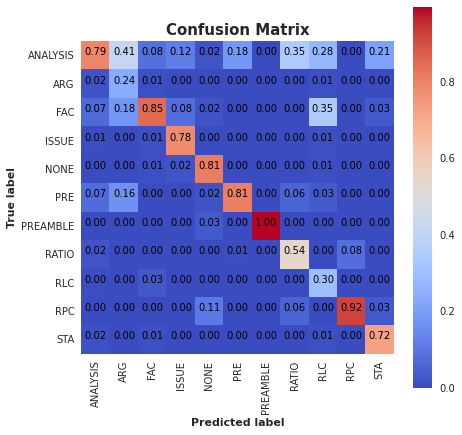

In [31]:
model = torch.load("bert-base-cnnbilstm.pth")
cm = None
for i in range(29):
    TEST_emb = load_tensor(filepath=f"../test_document/doc_{i}/embedding")
    TEST_labels = load_tensor(filepath=f"../test_document/doc_{i}/label")
    TEST_labels = remap_targets(TEST_labels, label_encoder_old, label_encoder_new)
    conf_matrix_helper = calculate_confusion_matrix(TEST_emb, TEST_labels, model, num_labels= 11)
    if cm is None:
        cm = conf_matrix_helper
    else:
        cm = np.add(cm, conf_matrix_helper)
plot_confusion_matrix(cm);

In [19]:
model6 = torch.load('bert-inlegal-cnnbilstm.pth')
cm = None
for i in range(29):
    TEST_emb = load_tensor(filepath=f"test_document/doc_{i}_inlegal/embedding")
    TEST_labels = load_tensor(filepath=f"test_document/doc_{i}_inlegal/label")
    TEST_labels = remap_targets(TEST_labels, label_encoder_old, label_encoder_new)
    conf_matrix_helper = calculate_confusion_matrix(TEST_emb, TEST_labels, model6, num_labels= 11)
    if cm is None:
        cm = conf_matrix_helper
    else:
        cm = np.add(cm, conf_matrix_helper)
        
accuracies = class_accuracy(cm)
f1_scores = class_f1_score(cm)
precision, recall = class_wise_precision_recall(cm)
print(np.mean(precision))
print(np.mean(recall))

0.7029825992183176
0.7086592111262816


In [20]:
for i in range(len(precision)):
    print(f"& {precision[i]:.2f} & {recall[i]:.2f} & {f1_scores[i]:.2f} ")

& 0.77 & 0.80 & 0.78 
& 0.51 & 0.49 & 0.50 
& 0.88 & 0.78 & 0.83 
& 0.78 & 0.72 & 0.75 
& 0.90 & 0.88 & 0.89 
& 0.68 & 0.60 & 0.64 
& 1.00 & 0.98 & 0.99 
& 0.46 & 0.55 & 0.50 
& 0.20 & 0.68 & 0.31 
& 0.88 & 0.89 & 0.88 
& 0.69 & 0.43 & 0.53 


/tmp/ipykernel_384/4076158040.py:25: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


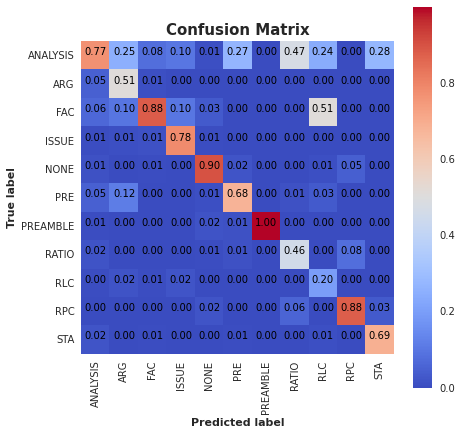

In [21]:
plot_confusion_matrix(cm);